# SUP ML 1 - PREPROCESSING

# Librerias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings("ignore")
import math

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output="pandas")
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

# Functions

## Función para separar datos en numéricos y categóricas (f1)

In [ ]:
# Función para separar datos en numéricos y categóricas
def separar_numericas_categoricas(df):
    # Seleccionar todas las columnas de tipo numérico
    numerical_columns = df.select_dtypes(include="number").columns.to_list()

    # Seleccionar todas las columnas que no son de tipo numérico
    categorical_columns = df.select_dtypes(exclude="number").columns.to_list()

    # Devolver las dos listas: columnas numéricas y categóricas
    return numerical_columns, categorical_columns

## Función para obtener estadísticas (f2)

In [ ]:
# Función para obtener estadísticas
def obtener_estadisticas(df, tipo="numerico", val_unique=5,round_dig=3):

    if tipo == "numerico":
        # Obtener estadísticas solo para columnas numéricas
        df_stats = df.describe(include="number").round(2).T

    elif tipo == "categorico":
        # Obtener estadísticas solo para columnas categóricas
        df_stats = df.describe(exclude="number").T
    else:
        raise ValueError("El parámetro 'tipo' debe ser 'numerico' o 'categorico'.")

    # Calcular el porcentaje de valores nulos para las columnas seleccionadas
    df_stats['%_nulos'] = df.isnull().mean().mul(100).round(round_dig)


    if tipo == "numerico":
        # Calcular el número de valores únicos para las columnas seleccionadas
        df_stats['n_unicos'] = df.nunique()
        # Obtener el nombre de la categoría más frecuente para las columnas seleccionadas
        df_stats['top'] = df.apply(lambda col: col.value_counts(dropna=False).idxmax())

    # Calcular el porcentaje que representa la categoría más frecuente para las columnas seleccionadas
    df_stats['%_top'] = df.apply(lambda col: col.value_counts(normalize=True, dropna=False).max() * 100).round(2)

    # Obtener una lista de los valores únicos (limitado a los primeros val_unique)
    df_stats['val_unicos'] = df.apply(lambda col: col.unique()[:val_unique])

    return df_stats

## Función para visualizar las variables numéricas con histograma (f3)

In [ ]:
# Función para visualizar las variables numéricas con histograma
def visualizar_variables_numericas_hist(df, numerical_columns, num_cols=4, bins=15):

    # Calcular el número de filas necesarias
    num_rows = len(numerical_columns) // num_cols + (len(numerical_columns) % num_cols > 0)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*2.5))
    axes = axes.flatten()  # Aplanar la matriz de ejes para iterar fácilmente

    # Generar los histogramas para cada columna numérica
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=False, bins=bins, ax=axes[i])
        axes[i].set_title(f'Histograma de {col}')
        axes[i].set_yscale('log')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

    # Eliminar los ejes vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar diseño para evitar superposición de gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

## Función para visualizar boxplot (f4)

In [ ]:
# Función para visualizar boxplot
def visualizar_variables_numericas_box(df, numerical_columns, num_cols=4):

    # Calcular el número de filas necesarias
    num_rows = len(numerical_columns) // num_cols + (len(numerical_columns) % num_cols > 0)

    # Crear la figura y los subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 2.5))

    # Asegurarse de que 'axes' sea un arreglo plano si hay múltiples subplots
    if num_rows > 1 or num_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    # Generar los boxplots para cada columna numérica
    for i, col in enumerate(numerical_columns):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(f'Boxplot de {col}')
        axes[i].set_xlabel(col)

    # Eliminar los ejes vacíos
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar el diseño para evitar superposición de gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

## Función que crea el heatmap y elimina las columnas con alta correlación (f5)

In [ ]:
# Definir la función que crea el heatmap y elimina las columnas con alta correlación
def plot_correlation_and_find_columns_to_drop(df, numerical_columns, target_col='churn'):
    # Calcular la matriz de correlación solo con las columnas numéricas
    corr_matrix = df[numerical_columns].corr()

    # Filtrar las correlaciones mayores a 0.95 (en valor absoluto), excluyendo las correlaciones de 1.0
    high_corr_pairs = corr_matrix[(corr_matrix.abs() > 0.95) & (corr_matrix != 1.0)]

    # Crear una lista para almacenar las columnas a eliminar
    columns_to_drop_corr = []

    # Recorrer las columnas y filas de la matriz de correlación filtrada
    for col in high_corr_pairs.columns:
        for idx in high_corr_pairs.index:
            if pd.notna(high_corr_pairs.loc[idx, col]) and col != target_col and idx != target_col:  # Evitar 'churn' con 'churn'
                # Obtener las correlaciones de 'churn' con las dos variables
                churn_corr_col = corr_matrix[target_col].get(col, None)
                churn_corr_with = corr_matrix[target_col].get(idx, None)

                # Comparar los valores absolutos de las correlaciones con 'churn' e identificar cuál eliminar
                if abs(churn_corr_col) > abs(churn_corr_with):
                    column_to_drop_corr = idx  # Si 'col' tiene mayor correlación con churn, se propone eliminar 'idx'
                else:
                    column_to_drop_corr = col  # Si 'idx' tiene mayor correlación con churn, se propone eliminar 'col'

                # Añadir la columna a eliminar a la lista
                columns_to_drop_corr.append(column_to_drop_corr)

    # Eliminar duplicados en la lista de columnas a eliminar
    columns_to_drop_corr = list(set(columns_to_drop_corr))

    # Crear una matriz de anotaciones donde solo las correlaciones > 0.95 sean visibles
    annot_matrix = corr_matrix.applymap(lambda x: f'{x:.2f}' if abs(x) > 0.95 else '')

    # Crear el heatmap de la matriz de correlación
    plt.figure(figsize=(40, 40))
    heatmap = sns.heatmap(corr_matrix,
                          annot=annot_matrix,
                          cmap='coolwarm',
                          fmt="",
                          linewidths=0.5,
                          annot_kws={"size": 12},
                          cbar_kws={'label': 'Correlación'})

    # Aumentar el tamaño de las etiquetas de la barra de color
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label('Correlación', fontsize=24)

    # Añadir título y cambiar tamaños de las fuentes
    plt.title('Heatmap de Correlaciones con Anotaciones > 0.95', fontsize=28)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Mostrar el gráfico
    plt.show()

    # Devolver la lista de columnas a eliminar
    return columns_to_drop_corr



## Función para visualizar las variables categóricas (f6)

In [ ]:
# Función para visualizar las variables categóricas

def visualizar_variables_categoricas(df, categorical_columns, target, num_cols=4):
    # Calcular el número de filas necesarias
    num_rows = len(categorical_columns) // num_cols + (len(categorical_columns) % num_cols > 0)

    # Crear la figura y los ejes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*2.5))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

    # Generar los gráficos de barras para cada columna categórica
    for i, col in enumerate(categorical_columns):
        sns.countplot(x=col, hue=target, data=df, ax=axes[i])  # Usar axes[i] en lugar de plt.subplot
        axes[i].set_title(f"Distribución de {target} por {col}")

    # Eliminar los ejes vacíos si existen
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajustar diseño para evitar superposición de gráficos
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


## Función para analizar nulos en las columnas (f7)

In [ ]:
# Función para analizar nulos en las columnas
def analizar_columnas_nulos(df):
    # Contar el número de valores nulos
    df_nulos = (df
                .isnull()
                .sum()
                .to_frame(name='count_nulos')
                .reset_index()
               )

    # Renombrar la columna del índice
    df_nulos.columns = ['variable', 'count_nulos']

    # Calcular el porcentaje de valores nulos
    df_nulos['%_nulos'] = (df_nulos['count_nulos'] / len(df)) * 100

    # Calcular el número de valores únicos
    df_nulos['unique_count'] = df.apply(lambda col: col.nunique()).values

    # Obtener la lista de valores únicos para cada columna
    df_nulos['unique_values'] = df.apply(lambda col: col.unique().tolist()).values

    # Ordenar por porcentaje de valores nulos de mayor a menor
    df_nulos = df_nulos.sort_values('%_nulos', ascending=False)

    # Filtrar solo las columnas con valores nulos mayores a 0%
    df_nulos = df_nulos[df_nulos['%_nulos'] > 0]

    # Mostrar el DataFrame con valores nulos, valores únicos y lista de valores únicos
    return df_nulos



## Función para identificar las columnas no binarias (f8)

In [ ]:
# Función para identificar las columnas no binarias
def encontrar_columnas_no_binarias(df):
    # Lista para almacenar las columnas no binarias
    columnas_no_binarias = []

    # Iterar sobre cada columna en el DataFrame
    for col in df.columns:
        # Obtener los valores únicos de la columna
        valores_unicos = df[col].unique()

        # Verificar si los valores únicos no son 0 y 1
        if set(valores_unicos) != {0, 1}:
            columnas_no_binarias.append(col)

    return columnas_no_binarias

## Clase personalizada para reducir categorías en una lista específica de columnas (c1)

In [ ]:
# Clase personalizada para reducir categorías en una lista específica de columnas
class FrecuenciaAcumuladaReemplazar(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_reduce=None, acumulado_threshold=90):
        self.acumulado_threshold = acumulado_threshold
        self.columns_to_reduce = columns_to_reduce if columns_to_reduce is not None else []
        self.lista_conservar_ = {}

    def fit(self, X, y=None):
        # Para cada columna en columns_to_reduce, calcular la frecuencia y el porcentaje acumulado
        for column in self.columns_to_reduce:
            frecuencia = X[column].value_counts().reset_index()
            frecuencia.columns = ['Categoria', 'Frecuencia']

            # Calcular el porcentaje sobre el total
            frecuencia['%_Columna'] = (frecuencia['Frecuencia'] / frecuencia['Frecuencia'].sum()) * 100
            # Calcular el porcentaje acumulado
            frecuencia['%_Acumulado'] = frecuencia['%_Columna'].cumsum()

            # Crear la lista de categorías a conservar (aquellas cuyo porcentaje acumulado es <= acumulado_threshold)
            self.lista_conservar_[column] = frecuencia[frecuencia['%_Acumulado'] <= self.acumulado_threshold]['Categoria'].to_list()

        return self

    def transform(self, X):
        X_copy = X.copy()
        # Reemplazar las categorías que no están en la lista por 'Other' solo en las columnas especificadas
        for column in self.columns_to_reduce:
            X_copy[column] = X_copy[column].apply(lambda x: x if x in self.lista_conservar_[column] else "Other")
        return X_copy

## Clase personalizada para imputar outliers (c2)

In [ ]:
# Definir clase personalizada para imputar outliers
class OutlierImputer:
    def __init__(self, columns=None, factor=1.5):
        """
        Inicializa la clase OutlierImputer.

        Parámetros:
        columns (list): Lista de columnas sobre las que aplicar la imputación de outliers.
                        Si es None, se aplicará a todas las columnas.
        factor (float): El multiplicador para determinar los límites de los outliers.
                        El valor por defecto es 1.5 (es el estándar para el método IQR).
        """
        self.factor = factor
        self.columns = columns  # Columnas en las que se aplicará el tratamiento
        self.medianas = {}
        self.lower_bound = {}
        self.upper_bound = {}

    def fit(self, X):
        """
        Calcula los límites de los outliers y la mediana de las columnas seleccionadas.

        Parámetros:
        X (DataFrame): El conjunto de datos sobre el que se calcularán las estadísticas necesarias.
        """
        if self.columns is None:
            self.columns = X.columns  # Si no se pasan columnas, se procesan todas

        # Calcular Q1, Q3 e IQR solo para las columnas seleccionadas
        Q1 = X[self.columns].quantile(0.25)
        Q3 = X[self.columns].quantile(0.75)
        IQR = Q3 - Q1

        # Calcular límites de outliers
        self.lower_bound = Q1 - self.factor * IQR
        self.upper_bound = Q3 + self.factor * IQR

        # Calcular las medianas de cada columna
        self.medianas = X[self.columns].median()

    def transform(self, X):
        """
        Reemplaza los outliers con la mediana en las columnas seleccionadas.

        Parámetros:
        X (DataFrame): El conjunto de datos en el que se reemplazarán los outliers.

        Devuelve:
        DataFrame: Un nuevo DataFrame donde los outliers han sido reemplazados por la mediana de su respectiva columna.
        """
        X_imputado = X.copy()  # Hacer una copia del DataFrame original

        for col in self.columns:
            # Reemplazar valores fuera de los límites con la mediana
            X_imputado[col] = np.where((X[col] < self.lower_bound[col]) | (X[col] > self.upper_bound[col]),
                                       self.medianas[col],
                                       X[col])
        return X_imputado

    def fit_transform(self, X):
        """
        Ajusta el imputador (calculando los límites y medianas) y luego transforma los datos.

        Parámetros:
        X (DataFrame): El conjunto de datos sobre el que se ajustarán los límites y se aplicará la imputación de outliers.

        Devuelve:
        DataFrame: Un DataFrame donde los outliers han sido reemplazados por la mediana.
        """
        self.fit(X)  # Calcular límites y medianas
        return self.transform(X)  # Reemplazar outliers y devolver los datos transformados



# Importar train data

In [5]:
# Ruta en local
#file_traintest_path="telecom_churn_TRAINTEST.csv"
#file_predict_path="telecom_churn_PREDICT.csv"
#df=pd.read_csv(file_traintest_path)
#df_predecir =pd.read_csv(file_predict_path)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv("/content/drive/MyDrive/DSC-07-dscesp-0624-Entregable 2- Kovylina, Talón, González, Benítez y Arderiu/data/telecom_churn_TRAINTEST.csv")
df_predecir = pd.read_csv("/content/drive/MyDrive/DSC-07-dscesp-0624-Entregable 2- Kovylina, Talón, González, Benítez y Arderiu/data/telecom_churn_PREDICT.csv")

# EDA: Analisis Exploratorio

In [8]:
#Información general sobre dataset de TrainTest
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 100 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rev               89866 non-null  float64
 1   mou               89866 non-null  float64
 2   totmrc            89866 non-null  float64
 3   da                89866 non-null  float64
 4   ovrmou            89866 non-null  float64
 5   ovrrev            89866 non-null  float64
 6   vceovr            89866 non-null  float64
 7   datovr            89866 non-null  float64
 8   roam              89866 non-null  float64
 9   change_mou        89405 non-null  float64
 10  change_rev        89405 non-null  float64
 11  drop_vce          90000 non-null  float64
 12  drop_dat          90000 non-null  float64
 13  blck_vce          90000 non-null  float64
 14  blck_dat          90000 non-null  float64
 15  unan_vce          90000 non-null  float64
 16  unan_dat          90000 non-null  float

## Distribución del target

In [9]:
# Columna objetivo "churn"
target = 'churn'

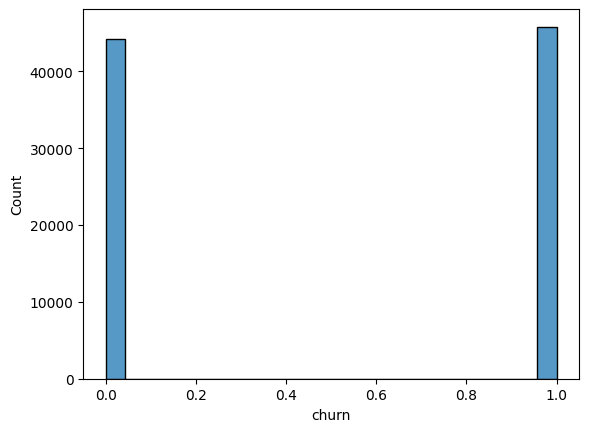

In [10]:
# Histograma de columna objetivo "churn"
sns.histplot(data=df, x=target)
plt.show()

In [11]:
# Calcular la distribución de la variable "churn" en porcentajes
print("Distribucion de churn (%):")
round(df["churn"].value_counts(normalize=True, dropna=False).mul(100),1)

Distribucion de churn (%):


churn
1    50.9
0    49.1
Name: proportion, dtype: float64

Dado que la distribución de la variable churn muestra que el 50.9% de los clientes se han ido (churn = 1) y el 49.1% no se han ido (churn = 0), se puede decir que el dataset está bastante equilibrado

## Analisis Univariable

* Distribución de cada variable.

Examinamos las columnas numericas

In [13]:
# Separar datos en numéricos y categóricas
numerical_columns, categorical_columns=separar_numericas_categoricas(df) #f1

In [15]:
# Obtener estadísticas completas
df_stats_num=obtener_estadisticas(df,val_unique=5) #f2
df_stats_num.sort_values(by="%_top",ascending=False)

count        mean       std         min         25%  \
callfwdv     90000.0        0.01      0.47        0.00        0.00   
recv_sms     90000.0        0.05      2.18        0.00        0.00   
blck_dat     90000.0        0.02      0.70        0.00        0.00   
drop_dat     90000.0        0.04      0.89        0.00        0.00   
unan_dat     90000.0        0.03      0.50        0.00        0.00   
forgntvl     88549.0        0.06      0.24        0.00        0.00   
peak_dat     90000.0        0.33      3.89        0.00        0.00   
mou_pead     90000.0        0.65      7.34        0.00        0.00   
opk_dat      90000.0        0.39      4.39        0.00        0.00   
mou_opkd     90000.0        1.04     16.99        0.00        0.00   
rv           88549.0        0.09      0.28        0.00        0.00   
comp_dat     90000.0        0.72      7.68        0.00        0.00   
mou_cdat     90000.0        1.69     21.91        0.00        0.00   
datovr       89866.0        0.24      3.01        0.00        0.00   
plcd_dat     90000.0        0.81      8.46        0.00        0.00   
truck        88549.0        0.20      0.40        0.00        0.00   
threeway     90000.0        0.27      1.00        0.00        0.00   
actvsubs     90000.0        1.37      0.66        0.00        1.00   
roam         89866.0        1.31     15.37        0.00        0.00   
models       89999.0        1.56      0.90        1.00        1.00   
uniqsubs     90000.0        1.56      1.10        1.00        1.00   
cc_mou       90000.0        3.44     10.05        0.00        0.00   
custcare     90000.0        1.65      5.15        0.00        0.00   
ccrndmou     90000.0        4.34     12.14        0.00        0.00   
phones       89999.0        1.80      1.32        1.00        1.00   
churn        90000.0        0.51      0.50        0.00        0.00   
callwait     90000.0        1.73      5.26        0.00        0.00   
da           89866.0        0.88      2.17        0.00        0.00   
numbcars     46432.0        1.57      0.63        1.00        1.00   
vceovr       89866.0       13.05     29.72        0.00        0.00   
ovrmou       89866.0       40.80     96.97        0.00        0.00   
ovrrev       89866.0       13.29     30.12        0.00        0.00   
iwylis_vce   90000.0        7.71     15.91        0.00        0.00   
mouiwylisv   90000.0       17.68     40.38        0.00        0.00   
lor          63498.0        6.18      4.74        0.00        2.00   
blck_vce     90000.0        4.00     10.60        0.00        0.00   
income       67804.0        5.81      2.18        1.00        4.00   
adults       69967.0        2.54      1.45        1.00        1.00   
hnd_price    89296.0       99.71     60.79        9.99       29.99   
drop_vce     90000.0        5.77      8.67        0.00        0.67   
inonemin     90000.0       28.91     54.96        0.00        2.33   
mouowylisv   90000.0       27.79     47.95        0.00        2.23   
owylis_vce   90000.0       24.27     33.91        0.00        3.00   
mou_rvce     90000.0      109.07    160.08        0.00        6.97   
drop_blk     90000.0        9.83     15.08        0.00        1.67   
recv_vce     90000.0       53.71     85.54        0.00        5.00   
unan_vce     90000.0       26.84     37.32        0.00        4.67   
change_rev   89405.0       -1.07     50.57    -1107.74       -7.21   
totmrc       89866.0       45.88     23.37      -26.92       30.00   
opk_vce      90000.0       64.10     89.74        0.00        9.67   
mou_opkv     90000.0      159.08    228.97        0.00       17.54   
mou_peav     90000.0      171.31    205.79        0.00       35.89   
peak_vce     90000.0       87.00    102.31        0.00       20.67   
mou_cvce     90000.0      221.36    257.22        0.00       46.84   
comp_vce     90000.0      106.48    116.85        0.00       27.33   
complete     90000.0      107.20    117.78        0.00       27.33   
attempt      90000.0     

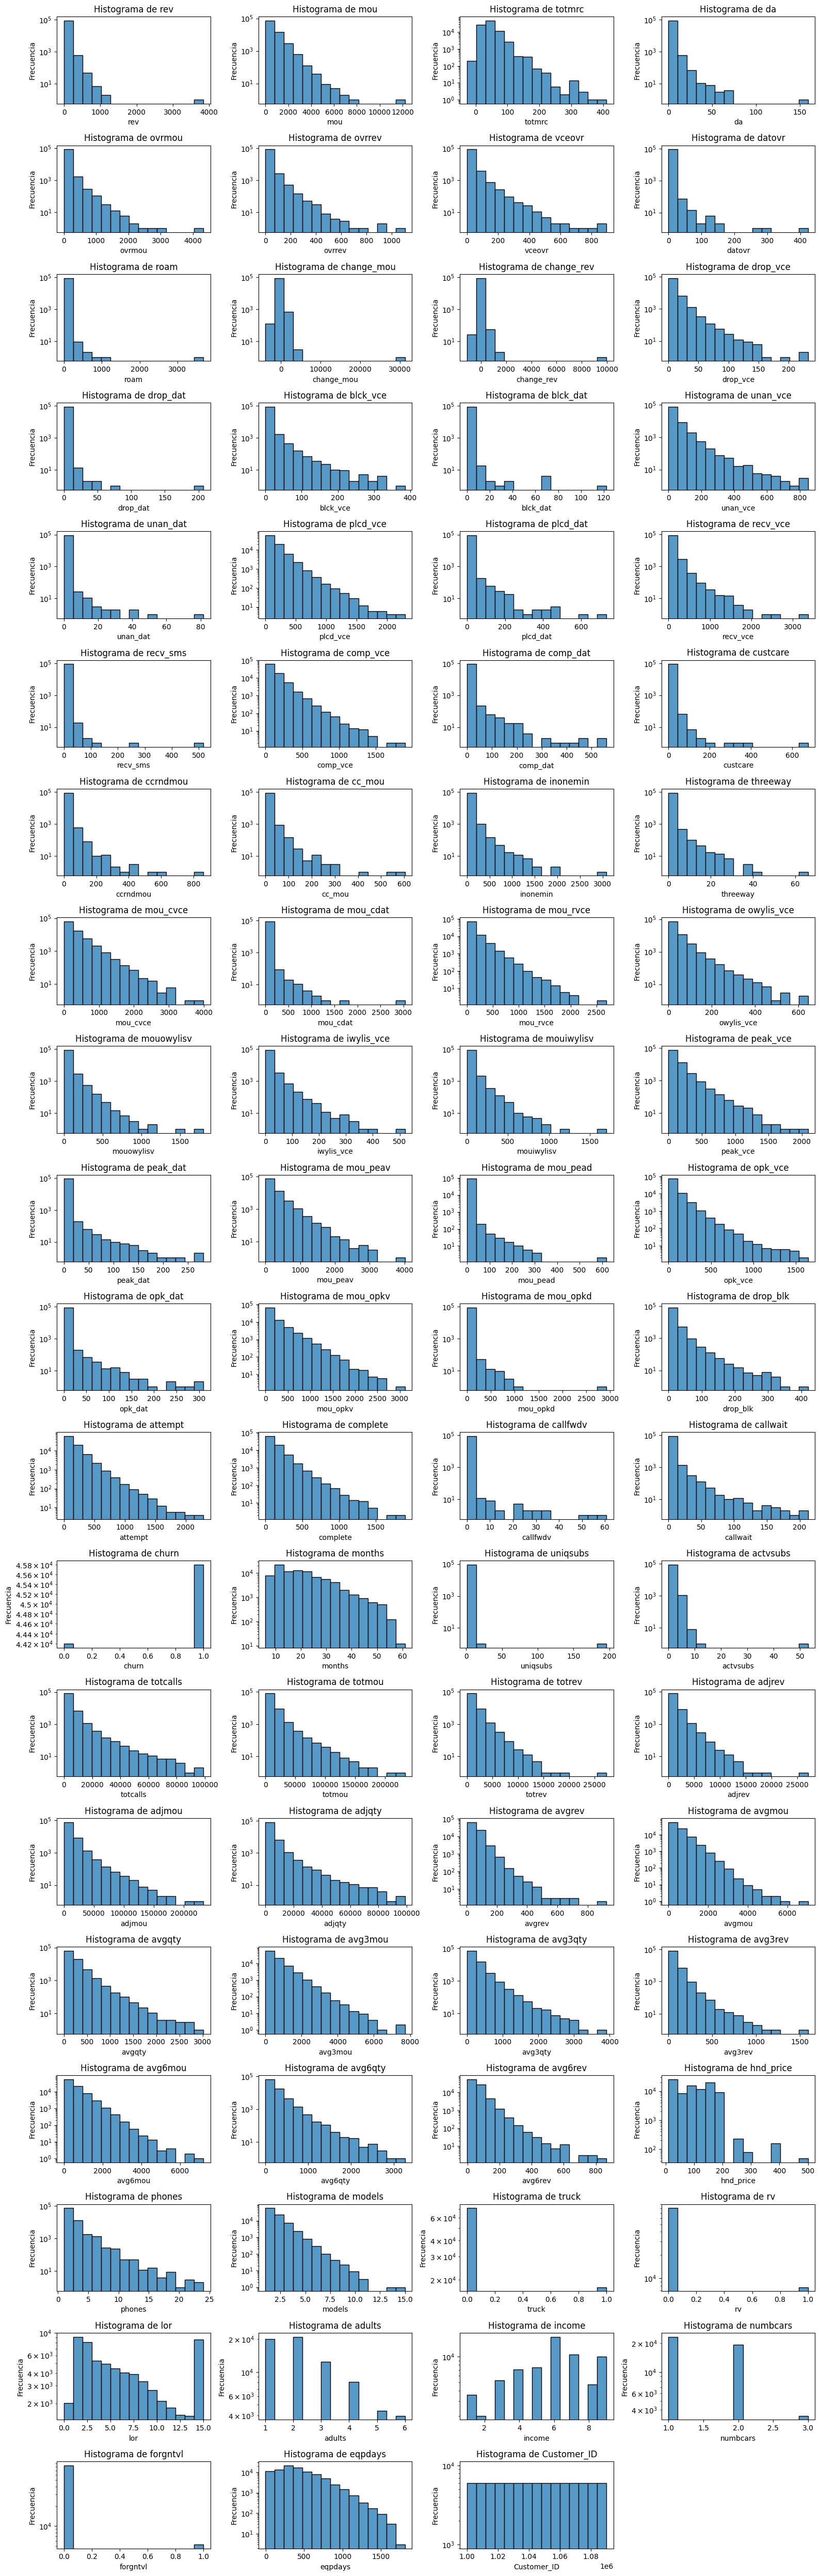

In [17]:
# Visualizamos las variables numericas
visualizar_variables_numericas_hist(df, numerical_columns) # f3

- Se ha identificado que algunas columnas contienen predominantemente valores nulos, un valor dominante, o están limitadas a un número reducido de categorías.
- Además, se observa que algunas columnas presentan una distribución logarítmica, mientras que otras siguen una distribución normal.

Las columnas que se excluirían del análisis por no aportar suficiente información son:

1. Identificador único: Customer_ID.
2. Cuartiles iguales o cercanos: Si los valores del primer cuartil (25%), la mediana (50%) y el tercer cuartil (75%) son iguales o muy similares, indica que la mayoría de los datos son iguales o casi iguales. En este caso, varias columnas tienen valores de 0 predominantes.
3. Dominadas por el valor mayoritario: Columnas donde un único valor domina la mayoría de los registros.



In [18]:
#Definir el umbral para la diferencia entre el percentil 75% y el percentil 25%
# y el umbral para la dominancia
quartile_threshold = 1e-3
dominance_threshold = 80

# Filtrar columnas numéricas que cumplan las condiciones:
# 1. La diferencia entre el percentil 75% y el 25% debe ser menor que quartile_threshold.
# 2. El valor en la columna '%_top' debe ser mayor que dominance_threshold.

cols_to_drop = df_stats_num[
    ((df_stats_num['75%'] - df_stats_num['25%']).abs() < quartile_threshold) &
    (df_stats_num['%_top'] > dominance_threshold)
].index.to_list()

cols_to_drop=cols_to_drop + ["Customer_ID"]

# Mostrar la lista de columnas que cumplen ambas condiciones
print(f"Columnas que se eliminarán por ser con baja diferencia entre cuartiles, tener valor dominante, o ser el identificador único ({ len(cols_to_drop)}):\n {cols_to_drop}")

Columnas que se eliminarán por ser con baja diferencia entre cuartiles, tener valor dominante, o ser el identificador único (16):
 ['datovr', 'drop_dat', 'blck_dat', 'unan_dat', 'plcd_dat', 'recv_sms', 'comp_dat', 'mou_cdat', 'peak_dat', 'mou_pead', 'opk_dat', 'mou_opkd', 'callfwdv', 'rv', 'forgntvl', 'Customer_ID']


In [19]:
# Comprobamos columnas que se van a eliminar
df_stats_num_drop=obtener_estadisticas(df[cols_to_drop],val_unique=5) #f2
df_stats_num_drop.sort_values(by="%_top",ascending=False)

count        mean       std        min         25%        50%  \
callfwdv     90000.0        0.01      0.47        0.0        0.00        0.0   
recv_sms     90000.0        0.05      2.18        0.0        0.00        0.0   
blck_dat     90000.0        0.02      0.70        0.0        0.00        0.0   
drop_dat     90000.0        0.04      0.89        0.0        0.00        0.0   
unan_dat     90000.0        0.03      0.50        0.0        0.00        0.0   
forgntvl     88549.0        0.06      0.24        0.0        0.00        0.0   
peak_dat     90000.0        0.33      3.89        0.0        0.00        0.0   
mou_pead     90000.0        0.65      7.34        0.0        0.00        0.0   
opk_dat      90000.0        0.39      4.39        0.0        0.00        0.0   
mou_opkd     90000.0        1.04     16.99        0.0        0.00        0.0   
rv           88549.0        0.09      0.28        0.0        0.00        0.0   
comp_dat     90000.0        0.72      7.68        0.0        0.00        0.0   
mou_cdat     90000.0        1.69     21.91        0.0        0.00        0.0   
datovr       89866.0        0.24      3.01        0.0        0.00        0.0   
plcd_dat     90000.0        0.81      8.46        0.0        0.00        0.0   
Customer_ID  90000.0  1045000.50  25980.91  1000001.0  1022500.75  1045000.5   

                    75%         max  %_nulos  n_unicos        top  %_top  \
callfwdv           0.00       60.67    0.000        40        0.0  99.57   
recv_sms           0.00      517.33    0.000        90        0.0  99.13   
blck_dat           0.00      122.33    0.000        45        0.0  98.82   
drop_dat           0.00      207.33    0.000        58        0.0  97.54   
unan_dat           0.00       81.67    0.000        47        0.0  97.04   
forgntvl           0.00        1.00    1.612         2        0.0  92.56   
peak_dat           0.00      281.00    0.000       214        0.0  91.45   
mou_pead           0.00      618.69    0.000      2871        0.0  91.45   
opk_dat            0.00      309.67    0.000       236        0.0  90.85   
mou_opkd           0.00     2922.04    0.000      3182        0.0  90.84   
rv                 0.00        1.00    1.612         2        0.0  89.84   
comp_dat           0.00      559.33    0.000       336        0.0  87.23   
mou_cdat           0.00     3032.05    0.000      3977        0.0  87.23   
datovr             0.00      423.54    0.149       689        0.0  86.97   
plcd_dat           0.00      733.67    0.000       354        0.0  85.72   
Customer_ID  1067500.25  1090000.00    0.000     90000  1000001.0   0.00   

                                                    val_unicos  
callfwdv     [0.0, 2.333333333, 0.333333333, 0.666666667, 1...  
recv_sms     [0.0, 5.0, 1.666666667, 3.333333333, 0.666666667]  
blck_dat     [0.0, 0.333333333, 0.666666667, 2.0, 1.333333333]  
drop_dat     [0.0, 0.333333333, 0.666666667, 1.0, 1.666666667]  
unan_dat             [0.0, 0.333333333, 3.0, 0.666666667, 1.0]  
forgntvl                                       [0.0, 1.0, nan]  
peak_dat     [0.0, 0.333333333, 11.33333333, 7.333333333, 4.0]  
mou_pead     [0.0, 0.056666667, 9.54, 0.083333333, 24.14333...  
opk_dat      [0.0, 1.333333333, 0.333333333, 1.666666667, 2...  
mou_opkd           [0.0, 2.373333333, 1.29, 3.353333333, 5.71]  
rv                                             [0.0, 1.0, nan]  
comp_dat     [0.0, 0.333333333, 1.333333333, 11.33333333, 1...  
mou_cdat           [0.0, 0.056666667, 2.373333333, 9.54, 1.29]  
datovr                        [0.0, 0.975, 5.07, 0.2925, 0.39]  
plcd_dat     [0.0, 0.333333333, 1.333333333, 11.33333333, 1...  
Customer_ID      [1000001, 1000002, 1000003, 1000004, 1000005]

In [20]:
# Generar estadísticas descriptivas de TrainTest para columnas categóricas
df_stats_cat=obtener_estadisticas(df,"categorico", val_unique=52) # f2
df_stats_cat.sort_values(by="%_top",ascending=False)

count unique                 top   freq  %_nulos  %_top  \
kid0_2            88549      2                   U  84938    1.612  94.38   
kid3_5            88549      2                   U  84308    1.612  93.68   
kid6_10           88549      2                   U  81196    1.612  90.22   
kid11_15          88549      2                   U  80497    1.612  89.44   
kid16_17          88549      2                   U  79419    1.612  88.24   
asl_flag          90000      2                   N  79401    0.000  88.22   
refurb_new        89999      2                   N  76624    0.001  85.14   
infobase          70597      1                   M  70597   21.559  78.44   
hnd_webcap        80481      3                WCMB  67396   10.577  74.88   
dualband          89999      4                   Y  65977    0.001  73.31   
creditcd          88549      2                   Y  61716    1.612  68.57   
new_cell          90000      3                   U  58812    0.000  65.35   
ownrent           60509      2                   O  58729   32.768  65.25   
dwlltype          62022      2                   S  44521   31.087  49.47   
dwllsize          56236     15                   A  43118   37.516  47.91   
HHstatin          56968      6                   C  36093   36.702  40.10   
crclscod          90000     54                  AA  34152    0.000  37.95   
marital           88549      5                   U  33050    1.612  36.72   
ethnic            88549     16                   N  30400    1.612  33.78   
prizm_social_one  83463      5                   S  29203    7.263  32.45   
area              89960     19  NEW YORK CITY AREA  10293    0.044  11.44   

                                                         val_unicos  
kid0_2                                                  [U, Y, nan]  
kid3_5                                                  [U, Y, nan]  
kid6_10                                                 [U, Y, nan]  
kid11_15                                                [U, Y, nan]  
kid16_17                                                [U, Y, nan]  
asl_flag                                                     [N, Y]  
refurb_new                                              [N, R, nan]  
infobase                                                   [M, nan]  
hnd_webcap                                    [WCMB, WC, nan, UNKW]  
dualband                                          [Y, N, T, U, nan]  
creditcd                                                [Y, N, nan]  
new_cell                                                  [U, N, Y]  
ownrent                                                 [O, nan, R]  
dwlltype                                                [S, M, nan]  
dwllsize          [A, D, O, nan, E, J, C, B, I, N, K, L, G, H, M...  
HHstatin                                    [C, I, nan, B, A, G, H]  
crclscod          [A, EA, C, B, BA, D, G, CA, I, AA, J, U, Z, K,...  
marital                                        [S, M, A, U, B, nan]  
ethnic            [N, Z, U, I, S, F, J, M, H, G, D, O, nan, R, B...  
prizm_social_one                               [S, U, T, C, nan, R]  
area              [NORTHWEST/ROCKY MOUNTAIN AREA, CHICAGO AREA, ...

Se observa que algunas columnas están dominadas por un único valor, por lo que las eliminaremos de la consideración.

In [21]:
# Definir el umbral para la dominancia de variables categóricas
dominance_cat_threshold=88.23
cols_to_drop_cat=df_stats_cat[df_stats_cat["%_top"] > dominance_cat_threshold].index.to_list()

In [22]:
# Actualizar columnas para eliminar de consideración
cols_to_drop=cols_to_drop+cols_to_drop_cat

Analizamos las variables que tienen valores mínimos negativos en df_stats_num

In [23]:
# Columnas que tienen valores mínimos negativos
negative_min_cols=df_stats_num[df_stats_num['min']<0].index.to_list()
print(f"Columnas con valores minimos negativos: {negative_min_cols}")

Columnas con valores minimos negativos: ['rev', 'totmrc', 'change_mou', 'change_rev', 'avg6rev', 'eqpdays']


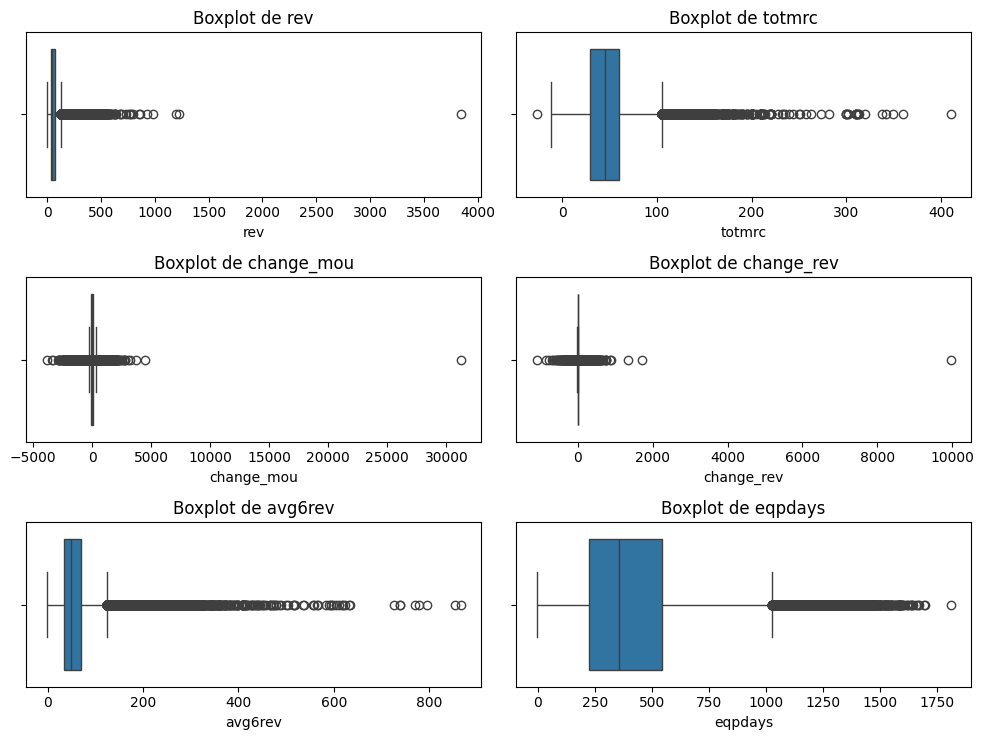

In [25]:
# Visualizar las variables numéricas
visualizar_variables_numericas_box(df, negative_min_cols, num_cols=2) #f4

No es posible que la edad del equipo (eqpdays: número de días de antigüedad del equipo actual) sea negativa. Dado que son pocas, eliminaremos esas filas del dataset. El resto de las variables podrían tener valores negativos debido a su distribución y al significado de sus respectivos campos.

## Analisis Variable-Target

* Relación target-variable

Analizamos variables numéricas y su relación con la variable objetivo "churn"

In [26]:
# Calcular correlación entre cada columna numérica y 'churn'
correlation_series = df[numerical_columns].corrwith(df['churn'])

# Eliminar la correlación de 'churn' consigo misma
correlation_series = correlation_series.drop("churn")

# Mostrar la serie
print(f"Correlacion entre churn y variables:\n{correlation_series}")

Correlacion entre churn y variables:
rev           -0.014413
mou           -0.057974
totmrc        -0.067390
da            -0.017076
ovrmou         0.016329
ovrrev         0.021385
vceovr         0.021588
datovr         0.001098
roam           0.008761
change_mou    -0.032353
change_rev     0.008682
drop_vce      -0.013247
drop_dat      -0.004952
blck_vce      -0.010954
blck_dat      -0.000825
unan_vce      -0.032688
unan_dat      -0.004334
plcd_vce      -0.047029
plcd_dat      -0.007389
recv_vce      -0.040898
recv_sms      -0.001859
comp_vce      -0.050651
comp_dat      -0.007206
custcare      -0.029300
ccrndmou      -0.034388
cc_mou        -0.032771
inonemin      -0.033247
threeway      -0.030062
mou_cvce      -0.051761
mou_cdat      -0.008764
mou_rvce      -0.046898
owylis_vce    -0.042393
mouowylisv    -0.036722
iwylis_vce    -0.040903
mouiwylisv    -0.035566
peak_vce      -0.049289
peak_dat      -0.006539
mou_peav      -0.050647
mou_pead      -0.007078
opk_vce       -0.044830
opk

No se encuentran variables con alta correlación con 'churn'

Verificamos si hay correlaciones entre variables y creamos una lista de columnas a eliminar, seleccionando aquella con menor correlación con 'churn', como umbral usaremos 0.95 que es una manera mas conservadora que preserva la información.

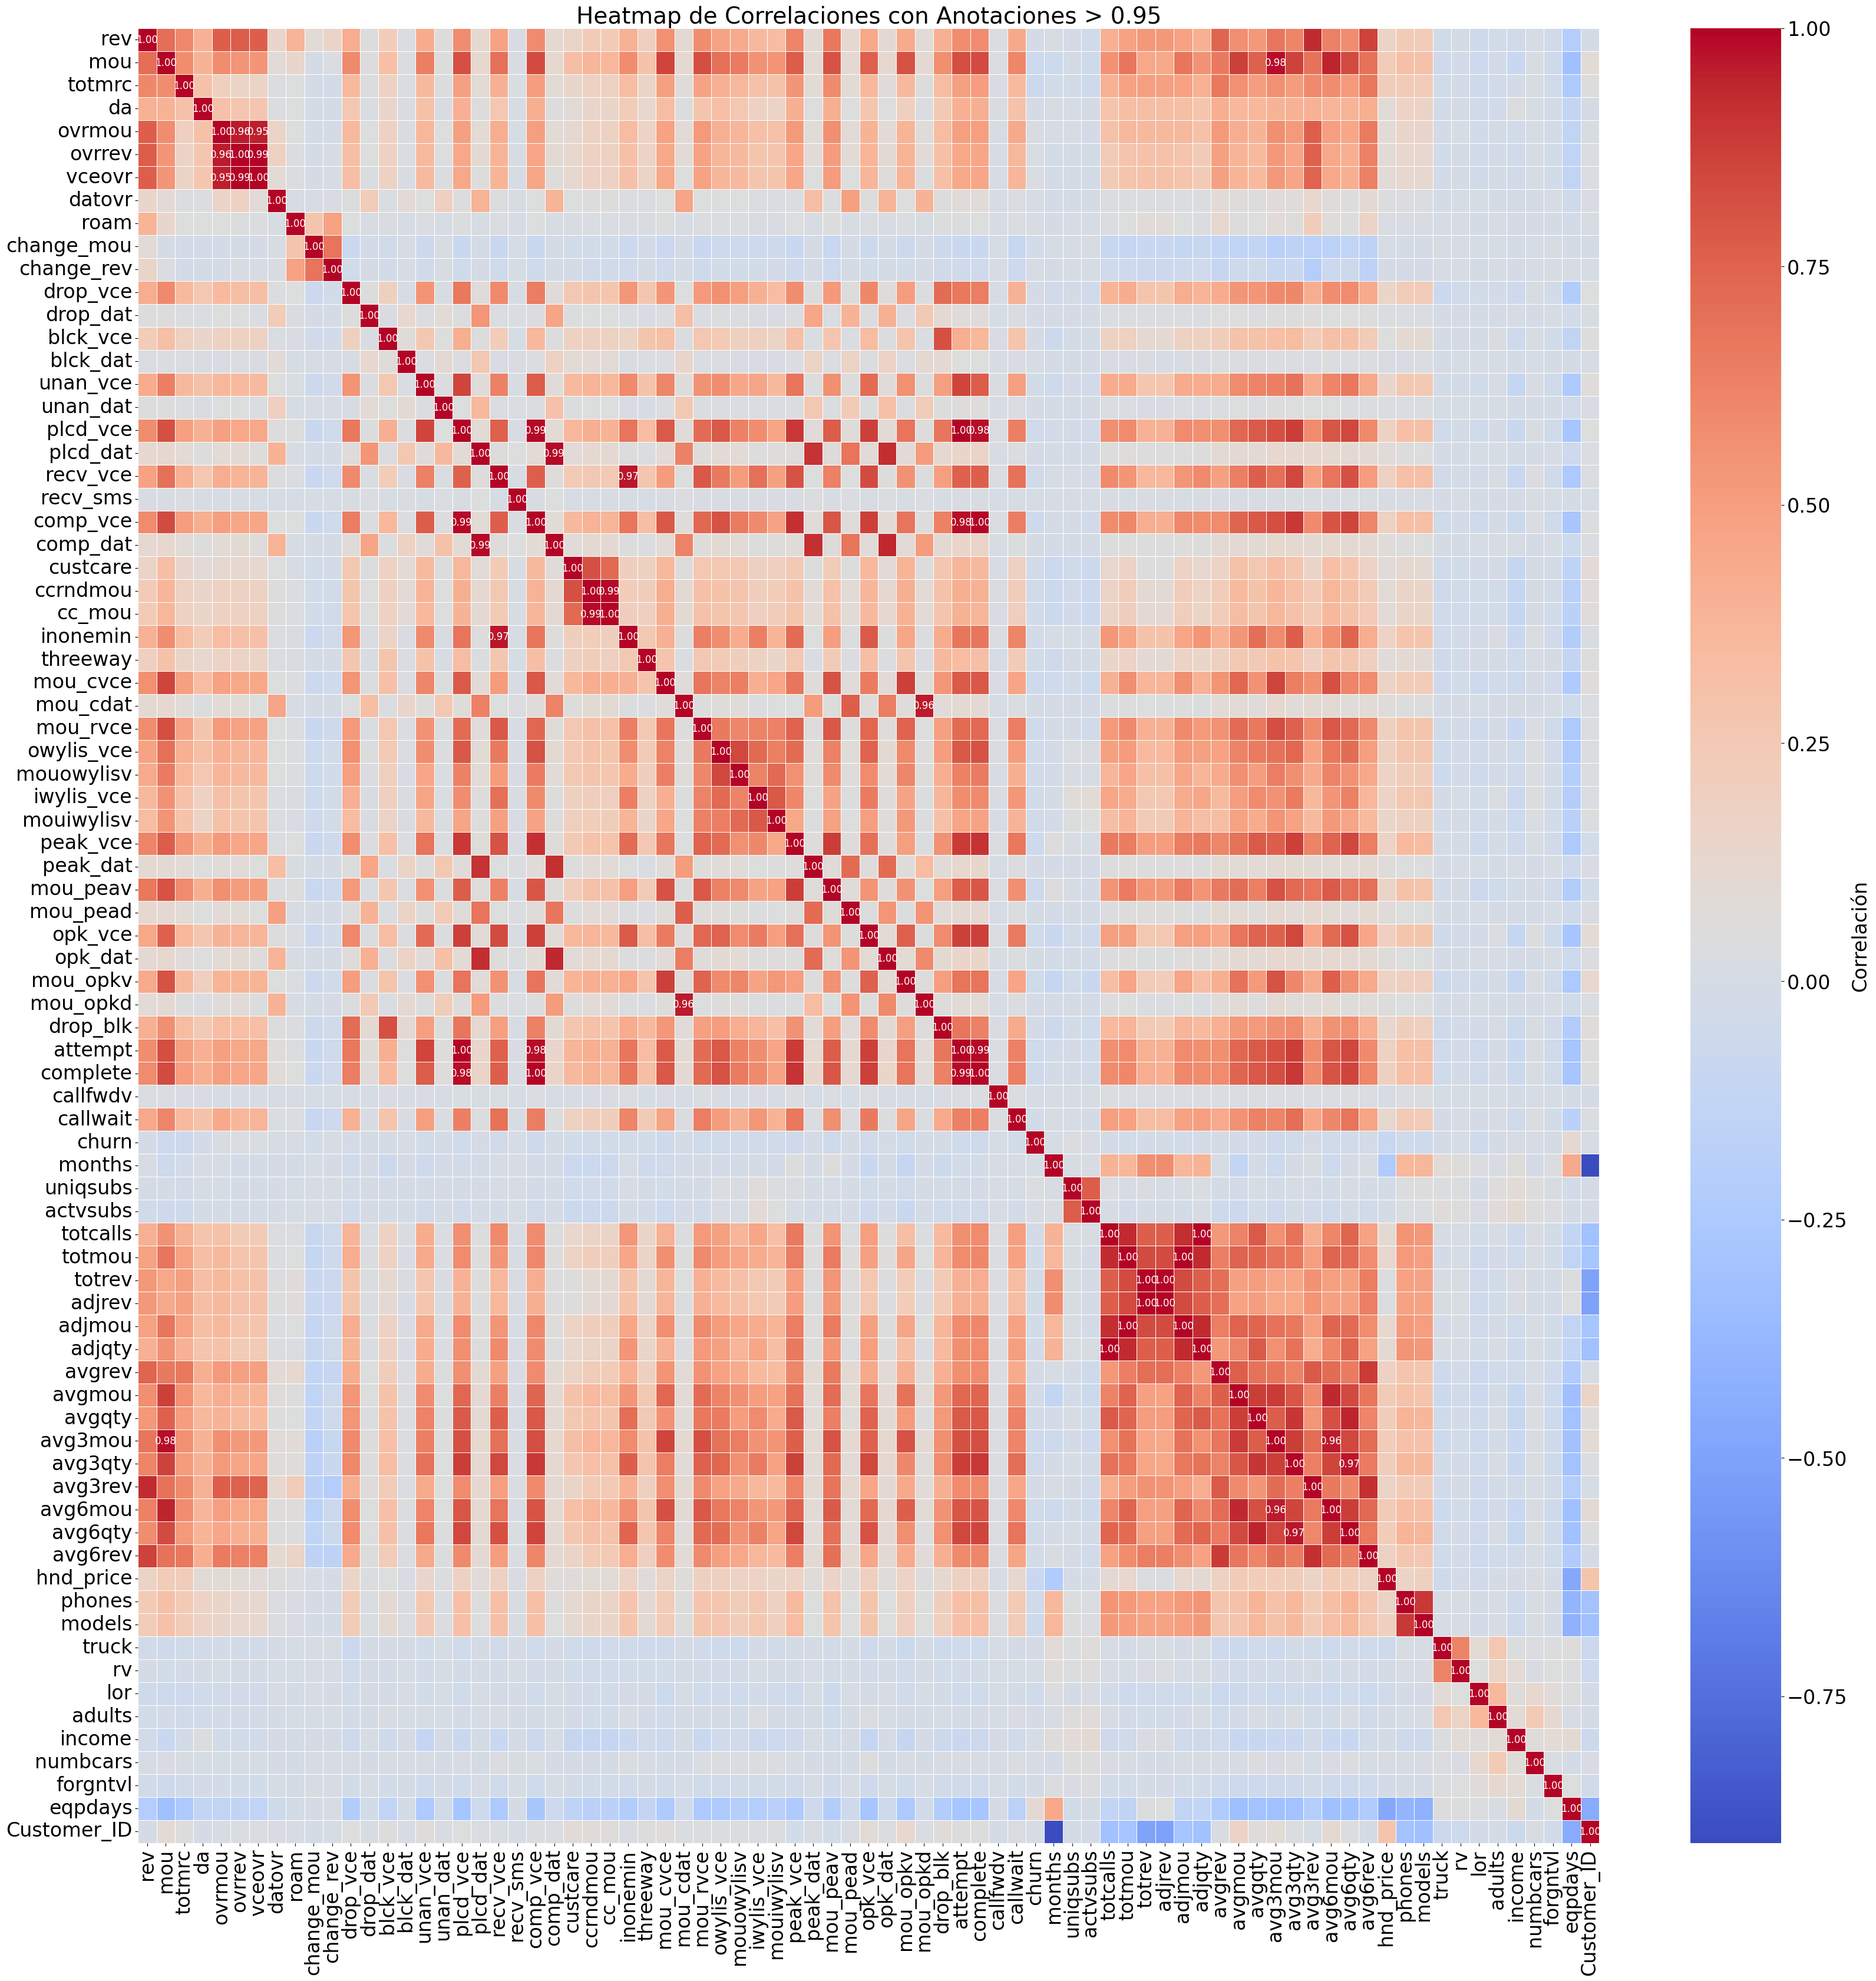

Columnas a eliminar:
 ['ovrmou', 'comp_vce', 'ovrrev', 'mou_opkd', 'comp_dat', 'totmou', 'avg6mou', 'avg6qty', 'totrev', 'inonemin', 'plcd_vce', 'attempt', 'avg3mou', 'cc_mou', 'totcalls']


In [28]:
# Visualizar la correlación
columns_to_drop_corr = plot_correlation_and_find_columns_to_drop(df, numerical_columns) # f5
print(f"Columnas a eliminar:\n {columns_to_drop_corr}")

Actualizamos la lista de columnas a eliminar

In [29]:
# Añadimos las columnas que descartamos por alta correlación entre ellas
cols_to_drop=list(set(columns_to_drop_corr+cols_to_drop))
print(f"Columnas para descartar de analisis despues de ver correlaciones ({len(cols_to_drop)}):\n{cols_to_drop}")

Columnas para descartar de analisis despues de ver correlaciones (34):
['blck_dat', 'kid3_5', 'comp_dat', 'totrev', 'inonemin', 'opk_dat', 'totcalls', 'mou_pead', 'ovrmou', 'comp_vce', 'callfwdv', 'avg6mou', 'avg6qty', 'peak_dat', 'datovr', 'kid6_10', 'kid0_2', 'Customer_ID', 'kid11_15', 'mou_cdat', 'avg3mou', 'plcd_dat', 'drop_dat', 'forgntvl', 'ovrrev', 'mou_opkd', 'totmou', 'kid16_17', 'rv', 'plcd_vce', 'attempt', 'recv_sms', 'cc_mou', 'unan_dat']


Analizamos variables categóricas y su relación con la variable objetivo "churn"

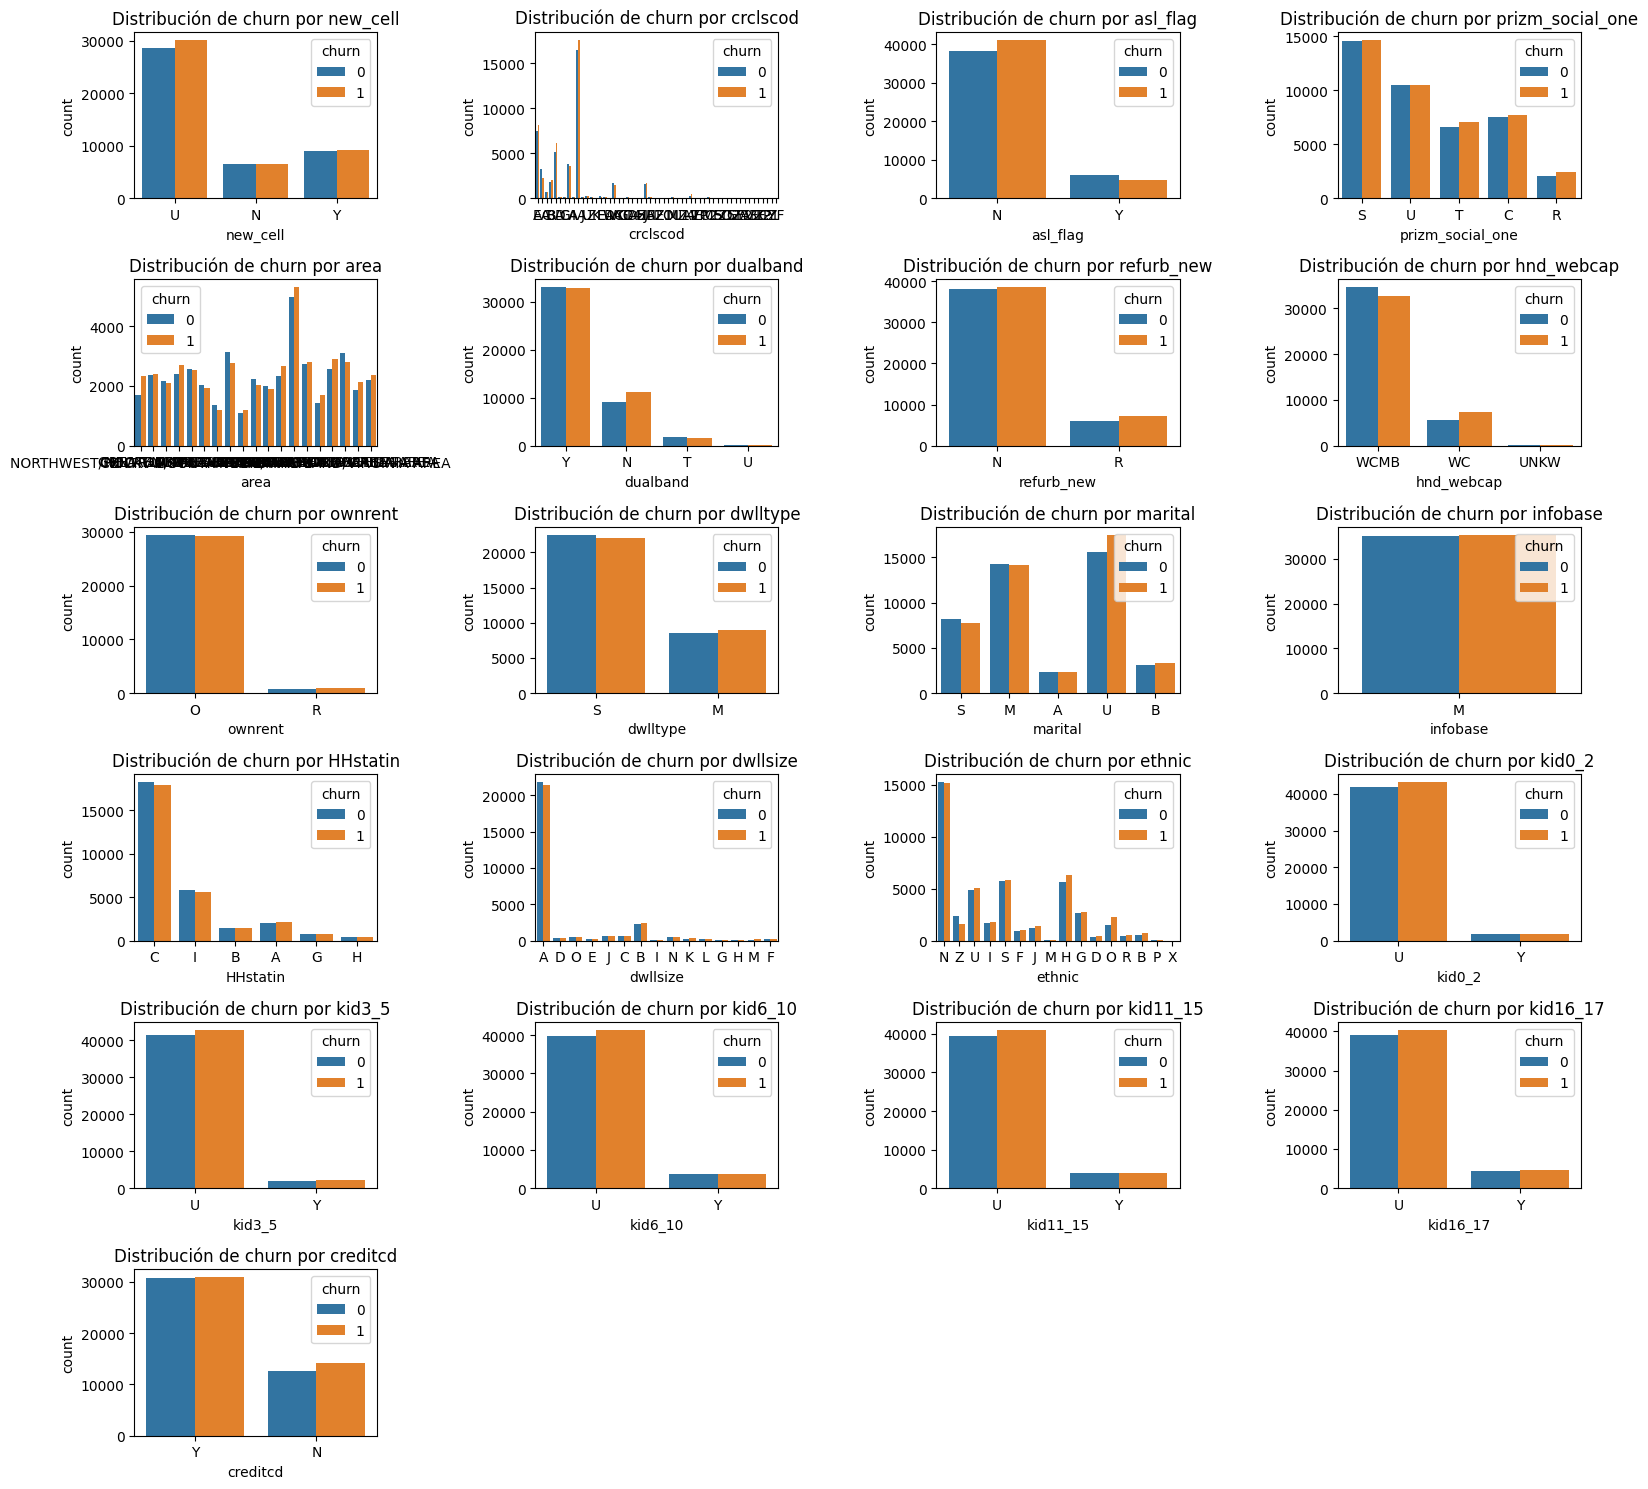

In [31]:
# Construimos countplotls de variables categóricas
visualizar_variables_categoricas(df, categorical_columns,target="churn") # f6

Se observa que algunas de las categorías de las variables categóricas están más correlacionadas con la probabilidad de churn que otras, por lo que se eliminarán aquellas con baja varianza y valor dominante cero después de aplicar el OneHotEncoder. Las variables categóricas que tienen muchas categorías deben reducirse antes de aplicar el OneHotEncoder

# Data Cleaning

* Eliminar filas sin target informado.
* Eliminar filas duplicadas (si tenemos ID, solo puede haber 1 registro por ID)
* Eliminar filas/columnas vacías y columnas irrelevantes
* Corregir data types incorrectos
* Categóricos: Corregir literales incorrectos (acentos, erratas, etc)
* Fechas y textos: convertir a variables numericas (hour, day, month, year...) o categoricas (weekday_name...)

In [32]:
# Mirar filas sin target informado
df[df[target].isnull()]

Empty DataFrame
Columns: [rev, mou, totmrc, da, ovrmou, ovrrev, vceovr, datovr, roam, change_mou, change_rev, drop_vce, drop_dat, blck_vce, blck_dat, unan_vce, unan_dat, plcd_vce, plcd_dat, recv_vce, recv_sms, comp_vce, comp_dat, custcare, ccrndmou, cc_mou, inonemin, threeway, mou_cvce, mou_cdat, mou_rvce, owylis_vce, mouowylisv, iwylis_vce, mouiwylisv, peak_vce, peak_dat, mou_peav, mou_pead, opk_vce, opk_dat, mou_opkv, mou_opkd, drop_blk, attempt, complete, callfwdv, callwait, churn, months, uniqsubs, actvsubs, new_cell, crclscod, asl_flag, totcalls, totmou, totrev, adjrev, adjmou, adjqty, avgrev, avgmou, avgqty, avg3mou, avg3qty, avg3rev, avg6mou, avg6qty, avg6rev, prizm_social_one, area, dualband, refurb_new, hnd_price, phones, models, hnd_webcap, truck, rv, ownrent, lor, dwlltype, marital, adults, infobase, income, numbcars, HHstatin, dwllsize, forgntvl, ethnic, kid0_2, kid3_5, kid6_10, kid11_15, kid16_17, creditcd, eqpdays, Customer_ID]
Index: []

No hay filas sin target informado

Verificamos si hay filas duplicadas

In [33]:
# Mirar duplicados
numero_duplicados_test=df.duplicated().sum()
numero_duplicados_predecir=df_predecir.duplicated().sum()
print(f"Filas duplicadas TrainTest: {numero_duplicados_test}, Predecir: {numero_duplicados_predecir}")

Filas duplicadas TrainTest: 0, Predecir: 0


Eliminar filas/columnas vacías y columnas irrelevantes

In [34]:
print(f"Filas con los valores negativos de 'eqpdays' en TrainTest: {len(df[df['eqpdays'] < 0])} y en Predecir: {len(df_predecir[df_predecir['eqpdays'] < 0])}")
print(f"Valores nulos en 'eqpdays' en TrainTest: {df['eqpdays'].isnull().sum()} y en Predecir: {df_predecir['eqpdays'].isnull().sum()}")

Filas con los valores negativos de 'eqpdays' en TrainTest: 102 y en Predecir: 31
Valores nulos en 'eqpdays' en TrainTest: 1 y en Predecir: 0


In [35]:
# Eliminar filas con valores negativos de 'eqpdays'
df = df[df['eqpdays'] >= 0].reset_index(drop=True)
df_predecir = df_predecir[df_predecir['eqpdays'] >= 0].reset_index(drop=True)

In [36]:
# Conservamos de momento "Customer_ID"
cols_to_drop.remove("Customer_ID")

# Eliminar columnas irrelevantes
df=df.drop(columns=cols_to_drop)
df_predecir=df_predecir.drop(columns=cols_to_drop)

In [37]:
# Verificar el dataset
print(f"Shape for TrainTest: {df.shape}, for Predecir: {df_predecir.shape}")

Shape for TrainTest: (89897, 67), for Predecir: (9969, 66)


# Imputación de nulos

* MODELOS DE ARBOLES: Imputar valor outlier.
* MODELOS LINEALES: imputar media, mediana o moda.
* Si vamos a practicar un Torneo de Modelos, preferible imputar valor outlier.

In [39]:
# Analizar cuantos valores nulos hay en TrainTest y cual es la mejor estrategia de imputarlos
resultado = analizar_columnas_nulos(df) # f7
resultado

variable  count_nulos    %_nulos  unique_count  \
60          numbcars        43506  48.395386             3   
62          dwllsize        33726  37.516269            15   
61          HHstatin        32999  36.707565             6   
53           ownrent        29449  32.758602             2   
55          dwlltype        27944  31.084463             2   
54               lor        26470  29.444809            16   
59            income        22167  24.658220             9   
57            adults        20010  22.258807             6   
58          infobase        19380  21.558005             1   
51        hnd_webcap         9517  10.586560             3   
44  prizm_social_one         6530   7.263869             5   
64          creditcd         1450   1.612957             2   
56           marital         1450   1.612957             5   
52             truck         1450   1.612957             2   
63            ethnic         1450   1.612957            16   
43           avg6rev         1405   1.562900           442   
48         hnd_price          668   0.743073            16   
6         change_mou          595   0.661869          7125   
7         change_rev          595   0.661869         30060   
1                mou          134   0.149059          9165   
0                rev          134   0.149059         35123   
5               roam          134   0.149059          5043   
4             vceovr          134   0.149059          7134   
3                 da          134   0.149059           162   
2             totmrc          134   0.149059          7665   
45              area           40   0.044495            19   

                                        unique_values  
60                               [3.0, 1.0, 2.0, nan]  
62  [A, D, O, nan, E, J, C, B, I, N, K, L, G, H, M...  
61                            [C, I, nan, B, A, G, H]  
53                                        [O, nan, R]  
55                                        [S, M, nan]  
54  [15.0, 1.0, 7.0, 6.0, 5.0, 8.0, 0.0, 3.0, 4.0,...  
59  [4.0, 5.0, 6.0, 9.0, 1.0, 7.0, 3.0, nan, 8.0, ...  
57                [1.0, 2.0, 4.0, 3.0, 5.0, nan, 6.0]  
58                                           [M, nan]  
51                              [WCMB, WC, nan, UNKW]  
44                               [S, U, T, C, nan, R]  
64                                        [Y, N, nan]  
56                               [S, M, A, U, B, nan]  
52                                    [0.0, 1.0, nan]  
63  [N, Z, U, I, S, F, J, M, H, G, D, O, nan, R, B...  
43  [38.0, 48.0, 17.0, 40.0, 80.0, 78.0, 58.0, 90....  
48  [149.9899902, nan, 29.98999023, 129.9899902, 7...  
6   [-157.25, 532.25, -4.25, -1.5, 38.5, 156.75, 0...  
7   [-18.9975, 50.9875, 0.0, 8.145, -0.155, -3.062...  
1   [219.25, 482.75, 10.25, 7.5, 570.5, 1312.25, 0...  
0   [23.9975, 57.4925, 16.99, 38.0, 55.23, 82.275,...  
5   [0.0, 35.4975, 1.3125, 1.285, 0.39, 2.565, 1.9...  
4   [0.0, 9.1, 41.95, 99.8, 1.5, 1.725, 5.6, 72.45...  
3   [0.2475, 0.0, 1.2375, 4.95, 2.475, 2.2275, 0.7...  
2   [22.5, 37.425, 16.99, 38.0, 71.98, 75.0, 52.49...  
45  [NORTHWEST/ROCKY MOUNTAIN AREA, CHICAGO AREA, ...

In [40]:
# Separar columnas con nulos en numéricas y categóricas
cols_nul=resultado["variable"].to_list()
numerical_columns_nul, categorical_columns_nul=separar_numericas_categoricas(df[cols_nul]) # f1

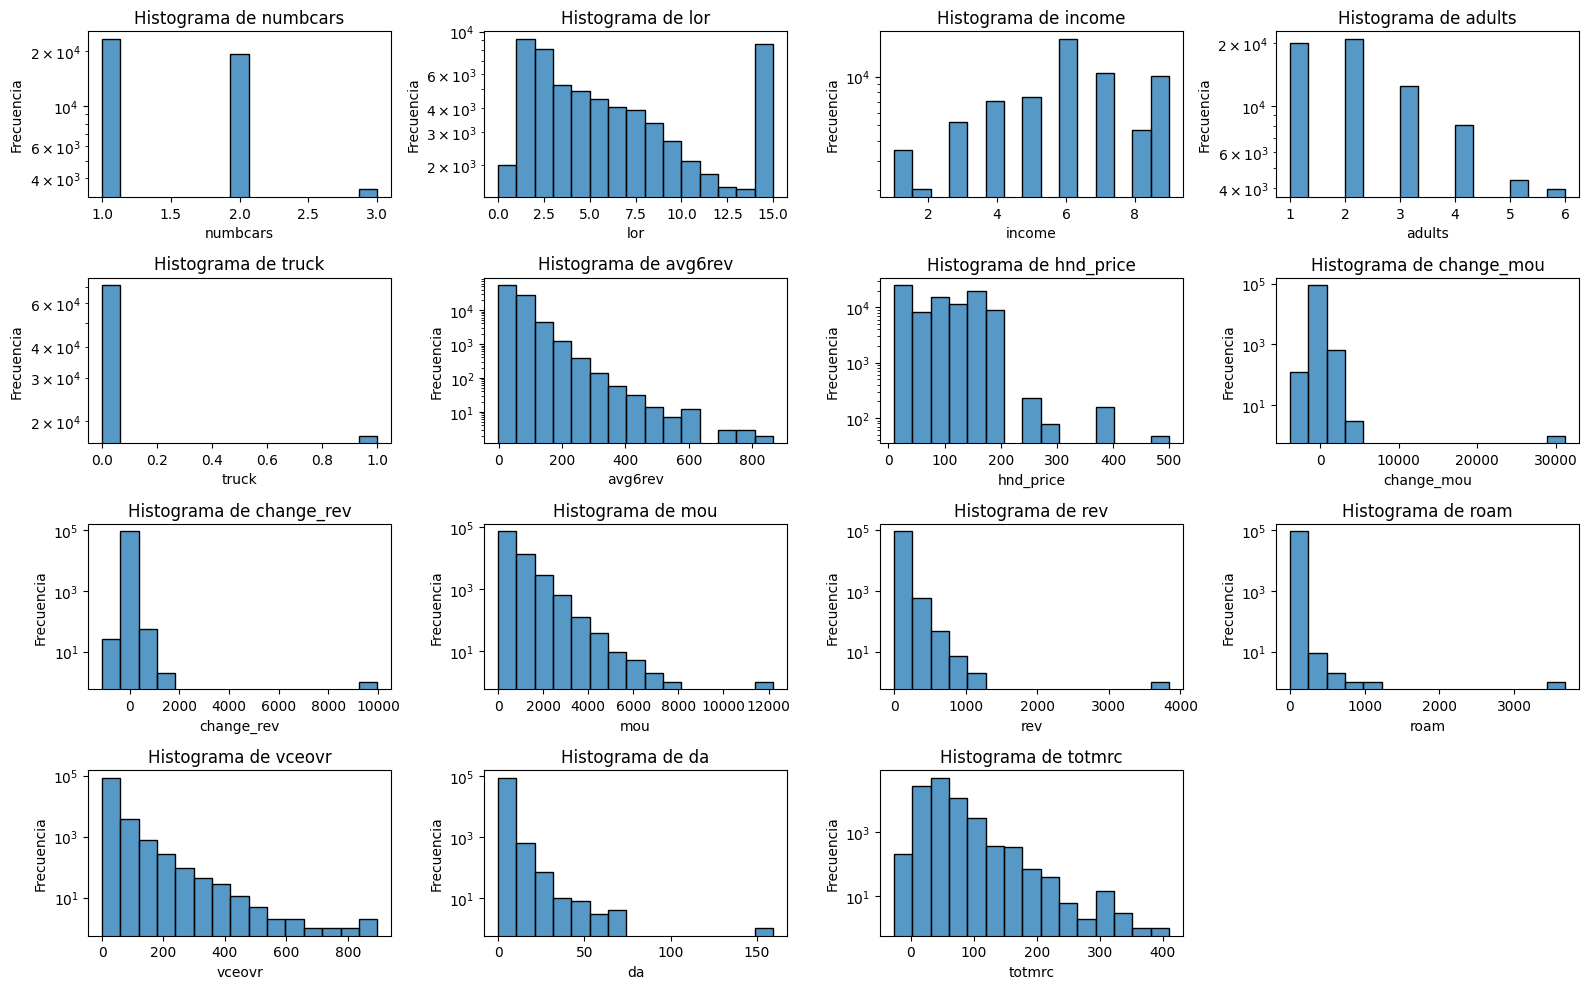

In [41]:
# Visualizar columnas numéricas con nulos
visualizar_variables_numericas_hist(df, numerical_columns_nul) # f3

Basándose en la forma de las distribuciones y en los datos estadísticos, se decide imputar los valores faltantes de la siguiente manera: con la mediana para las distribuciones logarítmicas, con la moda para las variables categóricas, con una constante para el número de coches y camiones, y con la media para el resto de las variables.

In [42]:
# Definir las columnas numéricas para diferentes estrategias de imputación
cols_num_fill_mediana=['vceovr','da','roam','rev','mou','avg6rev','hnd_price']
cols_num_fill_mean=['totmrc','change_rev','change_mou','lor']
cols_num_fill_const_cero=['numbcars','truck']
cols_num_fill_mode=['income','adults']

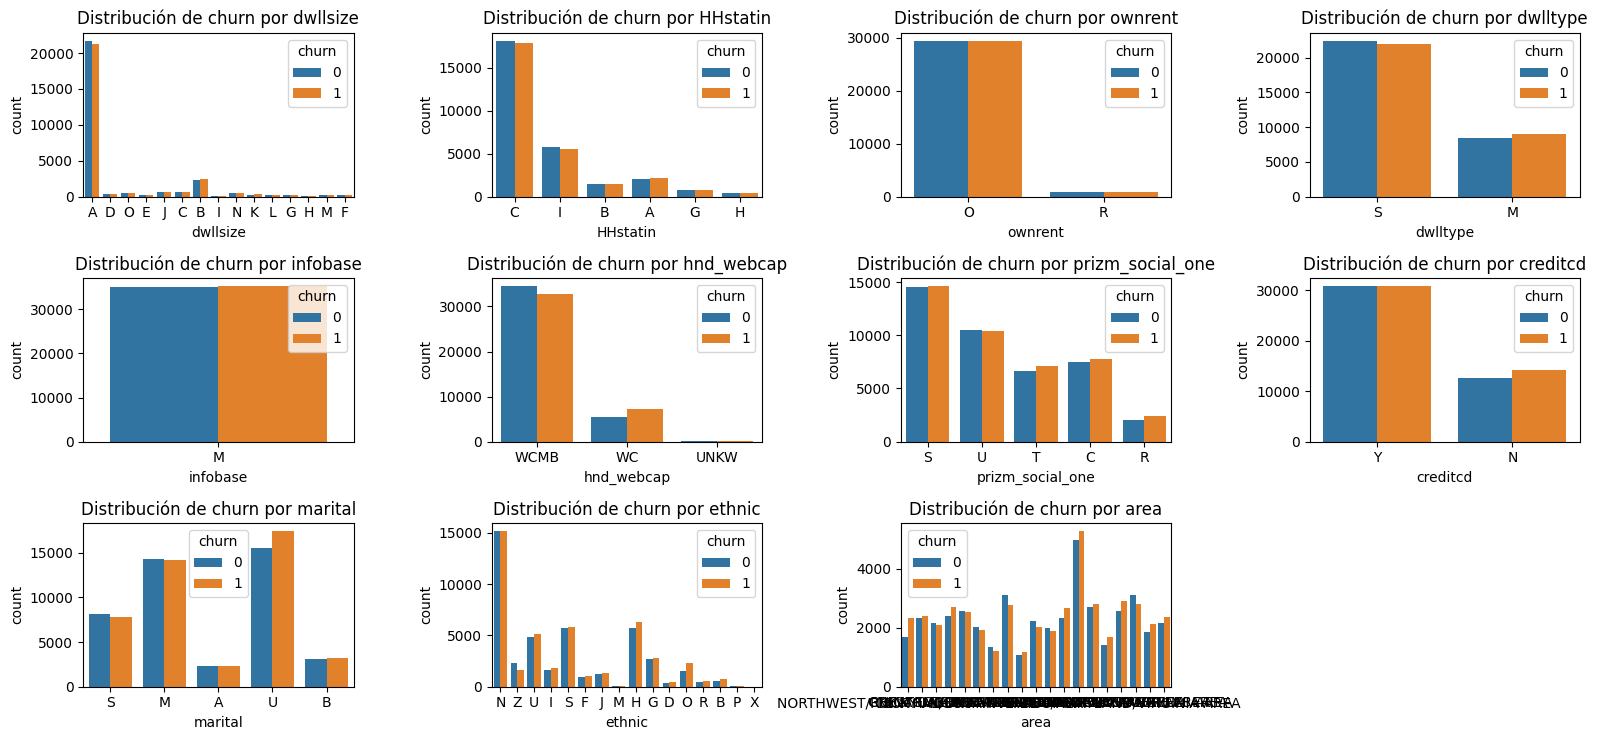

In [43]:
# Visualizar variables categóricas
visualizar_variables_categoricas(df, categorical_columns_nul,target) # f6

Se observa que 'hnd_webcap' tiene una categoria UNKW que sería "Unknown" que se va a imputar, asi que le cambiamos el nombre

In [44]:
# Reemplazar 'UNKW' por 'Unknown' en la columna 'hnd_webcap'
df['hnd_webcap'] = df['hnd_webcap'].replace('UNKW', 'Unknown')
df_predecir['hnd_webcap'] = df_predecir['hnd_webcap'].replace('UNKW', 'Unknown')

In [45]:
# Definir las columnas categóricas para diferentes estrategias de imputación
cols_cat_fill_mode=['creditcd', 'prizm_social_one']
cols_cat_fill_Unknown = list(set(categorical_columns_nul) - set(cols_cat_fill_mode))


Usaremos Column Transformer y SimpleImputer para imputar valores con diferentes estrategias a diferentes columnas

In [46]:
# Crear el ColumnTransformer
column_transformer_impute=ColumnTransformer(
    transformers=[
        ("num_median",SimpleImputer(strategy="median"),cols_num_fill_mediana),
        ("num_mean",SimpleImputer(strategy="mean"),cols_num_fill_mean),
        ("num_const_cero",SimpleImputer(strategy="constant",fill_value=0),cols_num_fill_const_cero),
        ("num_mode",SimpleImputer(strategy="most_frequent"),cols_num_fill_mode),
        ("cat_mode",SimpleImputer(strategy="most_frequent"),cols_cat_fill_mode),
        ("cat_Unknown",SimpleImputer(strategy="constant",fill_value='Unknown'),cols_cat_fill_Unknown)
    ], remainder='passthrough'
)

In [47]:
# Fiteamos y transformamos
y=df["churn"]
df_new=column_transformer_impute.fit_transform(df.drop(columns=["churn"]))
# Transformamos Predecir
df_predecir_new=column_transformer_impute.transform(df_predecir)


In [48]:
# Volver a los nombres de columnas originales antes de aplicar el Transformador
df_new.columns = df_new.columns.str.replace(r'^.*__', '', regex=True)
df_predecir_new.columns = df_predecir_new.columns.str.replace(r'^.*__', '', regex=True)

# Obtener el orden original de las columnas del DataFrame df
original_column_order = df.drop(columns=['churn']).columns

# Reorganizar las columnas de df_new para que coincidan con el orden de df
df_new = df_new[original_column_order]
df_predecir_new = df_predecir_new[original_column_order]

In [49]:
# Verificamos imputación de nulos
print(f"Valores nulos en TrainTest: {df_new.isnull().sum().sum()} y Predecir: {df_predecir_new.isnull().sum().sum()}")

Valores nulos en TrainTest: 0 y Predecir: 0


# Encoding categóricos

* Si tienen sentido ordinal, es decir, se pueden ordenar, encodear con una escala numerica. Ejemplo: {"Bajo":1, "Medio":2, "Alto":3}.
* Si tienen unicamente 2 clases, indicador booleano
* One Hot Encoding en resto de categoricos

In [50]:
# Separamos en numéricas y categóricas
numerical_columns_new, categorical_columns_new=separar_numericas_categoricas(df_new) # f1

In [51]:
# Inicializar el contador y la lista para reducir
counter_ohe = 0
lista_reducir = []

# Usar list comprehension para simplificar el proceso
for col in categorical_columns_new:
    unique_values = df_new[col].nunique()

    # Contabilizar las categorías de columnas con menos de 10 valores únicos
    counter_ohe += unique_values if unique_values < 10 else 0

    # Añadir a la lista si tienen más de 10 valores únicos
    if unique_values >= 10:
        lista_reducir.append(col)

    # Mostrar el nombre de la columna y sus valores únicos
    print(f"Columna ({unique_values} valores únicos): {col}")
    print(df_new[col].unique())
    print('-' * 50)

# Mostrar el resumen
print(f"Las categorías que se crearán con One-Hot Encoding sin reducir categorias: {counter_ohe}")
print(f"Columnas a reducir las categorías: {lista_reducir}")

Columna (3 valores únicos): new_cell
['U' 'N' 'Y']
--------------------------------------------------
Columna (54 valores únicos): crclscod
['A' 'EA' 'C' 'B' 'BA' 'D' 'G' 'CA' 'I' 'AA' 'J' 'U' 'Z' 'K' 'E' 'E4' 'W'
 'DA' 'Y' 'CC' 'GA' 'D4' 'D5' 'H' 'ZA' 'JF' 'B2' 'IF' 'Z1' 'O' 'M' 'L'
 'U1' 'Z4' 'A2' 'V' 'TP' 'EM' 'C2' 'C5' 'S' 'EC' 'Z5' 'D2' 'GY' 'ZY' 'E2'
 'A3' 'V1' 'EF' 'Z2' 'CY' 'P1' 'ZF']
--------------------------------------------------
Columna (2 valores únicos): asl_flag
['N' 'Y']
--------------------------------------------------
Columna (5 valores únicos): prizm_social_one
['S' 'U' 'T' 'C' 'R']
--------------------------------------------------
Columna (20 valores únicos): area
['NORTHWEST/ROCKY MOUNTAIN AREA' 'CHICAGO AREA' 'GREAT LAKES AREA'
 'NEW ENGLAND AREA' 'DALLAS AREA' 'CENTRAL/SOUTH TEXAS AREA'
 'TENNESSEE AREA' 'MIDWEST AREA' 'PHILADELPHIA AREA' 'OHIO AREA'
 'HOUSTON AREA' 'SOUTHWEST AREA' 'NEW YORK CITY AREA'
 'ATLANTIC SOUTH AREA' 'SOUTH FLORIDA AREA' 'CALIFORNIA 

In [52]:
# Usar una expresión regular para reemplazar espacios y barras por guiones bajos, y eliminar "_AREA" al final
df_new["area"] = df_new["area"].str.replace(r"[ /]", "_", regex=True).str.replace(r"_AREA$", "", regex=True)
df_predecir_new["area"] = df_predecir_new["area"].str.replace(r"[ /]", "_", regex=True).str.replace(r"_AREA$", "", regex=True)

In [53]:
# Hacer copias de datasets
df_new1=df_new.copy(deep=True)
df_predecir_new1=df_predecir_new.copy(deep=True)

In [55]:
# Mirar las estadísticas de DataSet para TrainTest
resultado=obtener_estadisticas(df_new, tipo="categorico", val_unique=5,round_dig=3) # f2
resultado

count unique            top   freq  %_nulos  %_top  \
new_cell          89897      3              U  58743      0.0  65.34   
crclscod          89897     54             AA  34123      0.0  37.96   
asl_flag          89897      2              N  79314      0.0  88.23   
prizm_social_one  89897      5              S  35702      0.0  39.71   
area              89897     20  NEW_YORK_CITY  10277      0.0  11.43   
dualband          89897      4              Y  65931      0.0  73.34   
refurb_new        89897      2              N  76545      0.0  85.15   
hnd_webcap        89897      3           WCMB  67337      0.0  74.90   
ownrent           89897      3              O  58669      0.0  65.26   
dwlltype          89897      3              S  44471      0.0  49.47   
marital           89897      6              U  33009      0.0  36.72   
infobase          89897      2              M  70517      0.0  78.44   
HHstatin          89897      7              C  36057      0.0  40.11   
dwllsize          89897     16              A  43071      0.0  47.91   
ethnic            89897     17              N  30361      0.0  33.77   
creditcd          89897      2              Y  63104      0.0  70.20   

                                                         val_unicos  
new_cell                                                  [U, N, Y]  
crclscod                                          [A, EA, C, B, BA]  
asl_flag                                                     [N, Y]  
prizm_social_one                                    [S, U, T, C, R]  
area              [NORTHWEST_ROCKY_MOUNTAIN, CHICAGO, GREAT_LAKE...  
dualband                                               [Y, N, T, U]  
refurb_new                                                   [N, R]  
hnd_webcap                                      [WCMB, WC, Unknown]  
ownrent                                             [O, Unknown, R]  
dwlltype                                            [S, M, Unknown]  
marital                                             [S, M, A, U, B]  
infobase                                               [M, Unknown]  
HHstatin                                      [C, I, Unknown, B, A]  
dwllsize                                      [A, D, O, Unknown, E]  
ethnic                                              [N, Z, U, I, S]  
creditcd                                                     [Y, N]

In [56]:
# Mirar las estadísticas de DataSet para Predecir
resultado_predecir=obtener_estadisticas(df_predecir_new, tipo="categorico", val_unique=5,round_dig=3) # f2
resultado_predecir

count unique          top  freq  %_nulos  %_top  \
new_cell          9969      3            U  8081      0.0  81.06   
crclscod          9969     45           AA  2353      0.0  23.60   
asl_flag          9969      2            N  6648      0.0  66.69   
prizm_social_one  9969      5            S  3734      0.0  37.46   
area              9969     19  LOS_ANGELES  2075      0.0  20.81   
dualband          9969      4            Y  6275      0.0  62.95   
refurb_new        9969      2            N  8950      0.0  89.78   
hnd_webcap        9969      3         WCMB  8311      0.0  83.37   
ownrent           9969      3            O  5541      0.0  55.58   
dwlltype          9969      3            S  4226      0.0  42.39   
marital           9969      6            U  4264      0.0  42.77   
infobase          9969      3            M  7082      0.0  71.04   
HHstatin          9969      7      Unknown  4873      0.0  48.88   
dwllsize          9969     16      Unknown  4529      0.0  45.43   
ethnic            9969     18            N  2981      0.0  29.90   
creditcd          9969      2            Y  5782      0.0  58.00   

                                                         val_unicos  
new_cell                                                  [U, Y, N]  
crclscod                                        [AA, EA, A, CA, DA]  
asl_flag                                                     [N, Y]  
prizm_social_one                                    [C, T, S, U, R]  
area              [ATLANTIC_SOUTH, NORTHWEST_ROCKY_MOUNTAIN, CEN...  
dualband                                               [Y, T, N, U]  
refurb_new                                                   [N, R]  
hnd_webcap                                      [WCMB, Unknown, WC]  
ownrent                                             [R, Unknown, O]  
dwlltype                                            [M, Unknown, S]  
marital                                       [M, U, S, B, Unknown]  
infobase                                            [M, Unknown, N]  
HHstatin                                      [C, Unknown, I, A, G]  
dwllsize                                      [Unknown, A, B, F, C]  
ethnic                                              [U, N, S, H, O]  
creditcd                                                     [Y, N]

In [57]:
# Hay que incluir en la lista de columnas "infobase" porque parece que tiene valores en el conjunto de Predecir que no están presentes en TrainTest
# Lo procesaremos con un pipeline en Column Transformer y asi se hará igual para ambos Datasets
lista_reducir = lista_reducir + ["infobase"]

# Lista para OneHotEncoder
# Convertimos 'resultado.index' a lista y eliminamos las columnas que están en 'lista_reducir'
lista_ohe = list(set(resultado.index.to_list()) - set(lista_reducir))

#Imprimimos el resultado
print(f"Lista a reducir({len(lista_reducir)}): {lista_reducir}")
print(f"Lista para ohe ({len(lista_ohe)}): {lista_ohe}")

Lista a reducir(5): ['crclscod', 'area', 'dwllsize', 'ethnic', 'infobase']
Lista para ohe (11): ['prizm_social_one', 'new_cell', 'dualband', 'HHstatin', 'marital', 'dwlltype', 'refurb_new', 'asl_flag', 'ownrent', 'creditcd', 'hnd_webcap']


In [58]:
# Crear un pipeline que primero reduce categorías y luego aplica OneHotEncoder
pipeline_reduccion_ohe=Pipeline(
    steps=[
        ('reduce_frecuencia', FrecuenciaAcumuladaReemplazar(columns_to_reduce=lista_reducir, acumulado_threshold=90)),  # c1 Reducir categorías en 'city'
        ('onehot', OneHotEncoder(drop='if_binary', sparse_output=False))  # Luego aplicar OneHotEncoder
    ])

In [59]:
# Definir el ColumnTransformer que aplica el pipeline para lista_reducir y OHE a otras columnas categóricas
column_transformer_reducir_ohe = ColumnTransformer(
    transformers=[
        ('pipeline_reducir', pipeline_reduccion_ohe, lista_reducir),  # Aplicar el pipeline a 'city'
        ('ohe', OneHotEncoder(drop='if_binary', sparse_output=False),lista_ohe)  # Aplicar OneHotEncoder a 'job'
    ],
    remainder='passthrough'  # Mantener las columnas numéricas sin cambios
)

In [60]:
# Aplicar el ColumnTransformer
df_clean = column_transformer_reducir_ohe.fit_transform(df_new1)
# Aplicar la misma transformación a los datos de predicción
df_clean_predecir = column_transformer_reducir_ohe.transform(df_predecir_new1)

In [61]:
# Volvemos a los nombres de columnas originales antes de aplicar el Transformador

df_clean.columns = df_clean.columns.str.replace(r'^.*__', '', regex=True)
df_clean_predecir.columns = df_clean_predecir.columns.str.replace(r'^.*__', '', regex=True)

In [62]:
# Añadir columna 'churn'
df_clean["churn"]=y

# Tratamiento de outliers

Miramos las columnas que no son binarias

In [64]:
# Identificar las columnas no binarias
columnas_no_binarias=encontrar_columnas_no_binarias(df_clean) # f9

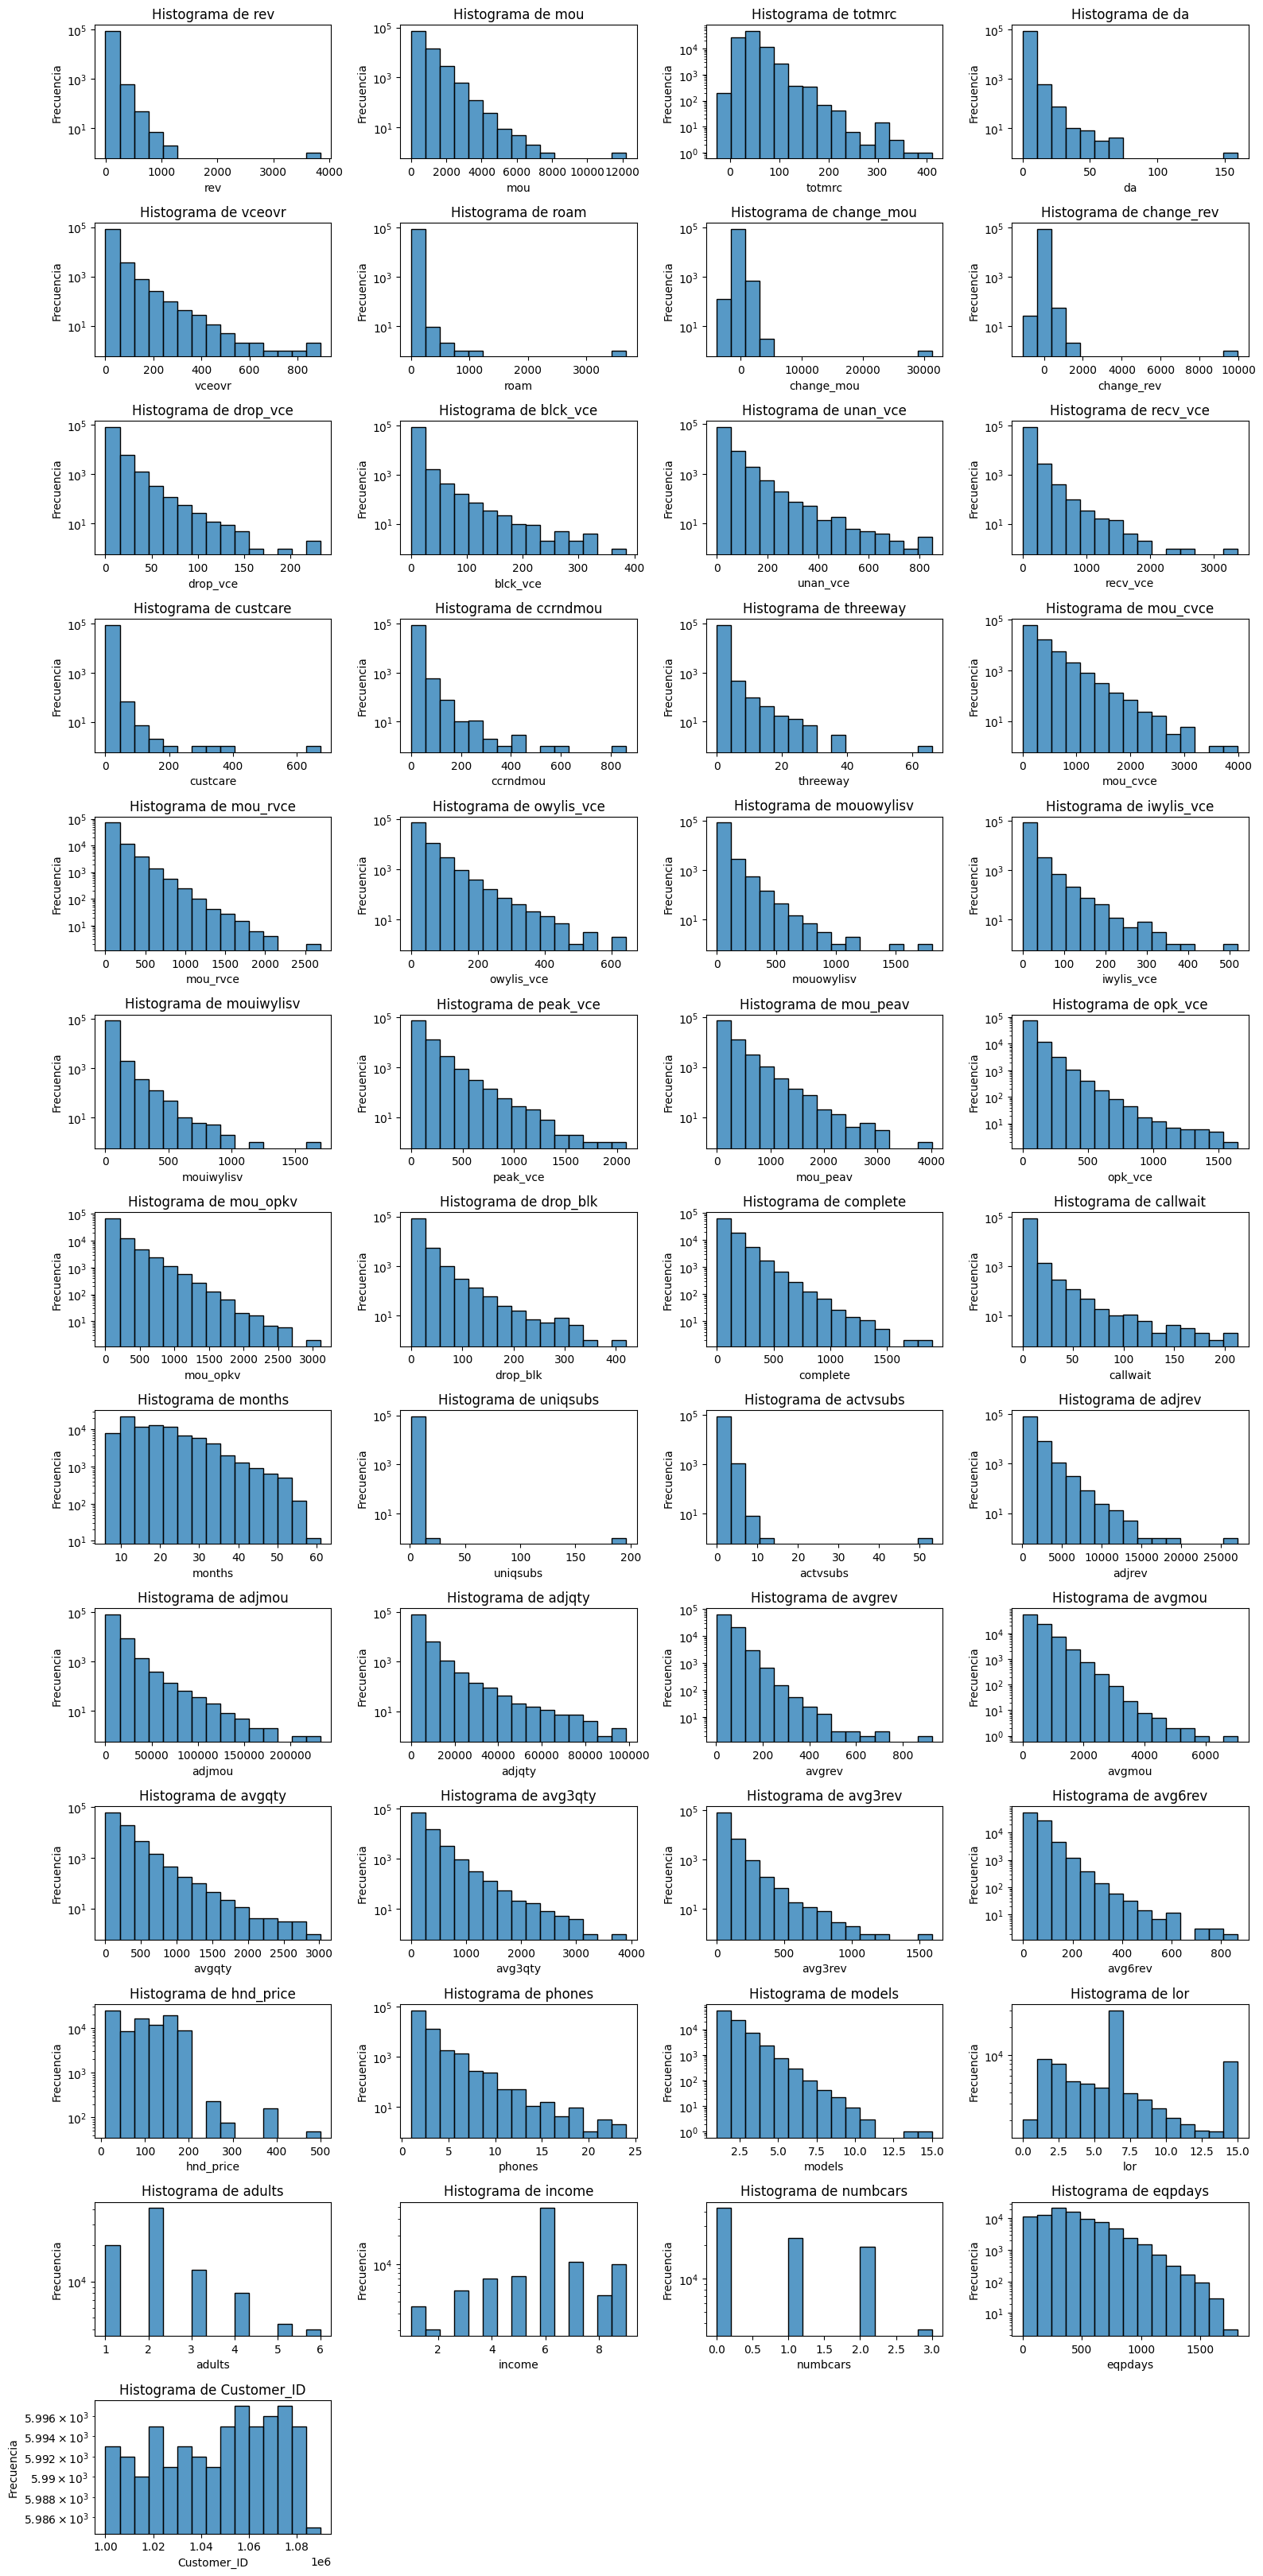

In [65]:
# Visualizamos las variables no binarias
visualizar_variables_numericas_hist(df_clean, columnas_no_binarias) # f3

In [66]:
# Vemos que hay variables con outliers posibles
lista_outlyers=["uniqsubs","actvsubs","hnd_price", "rev", "da","roam","change_mou","change_rev"]

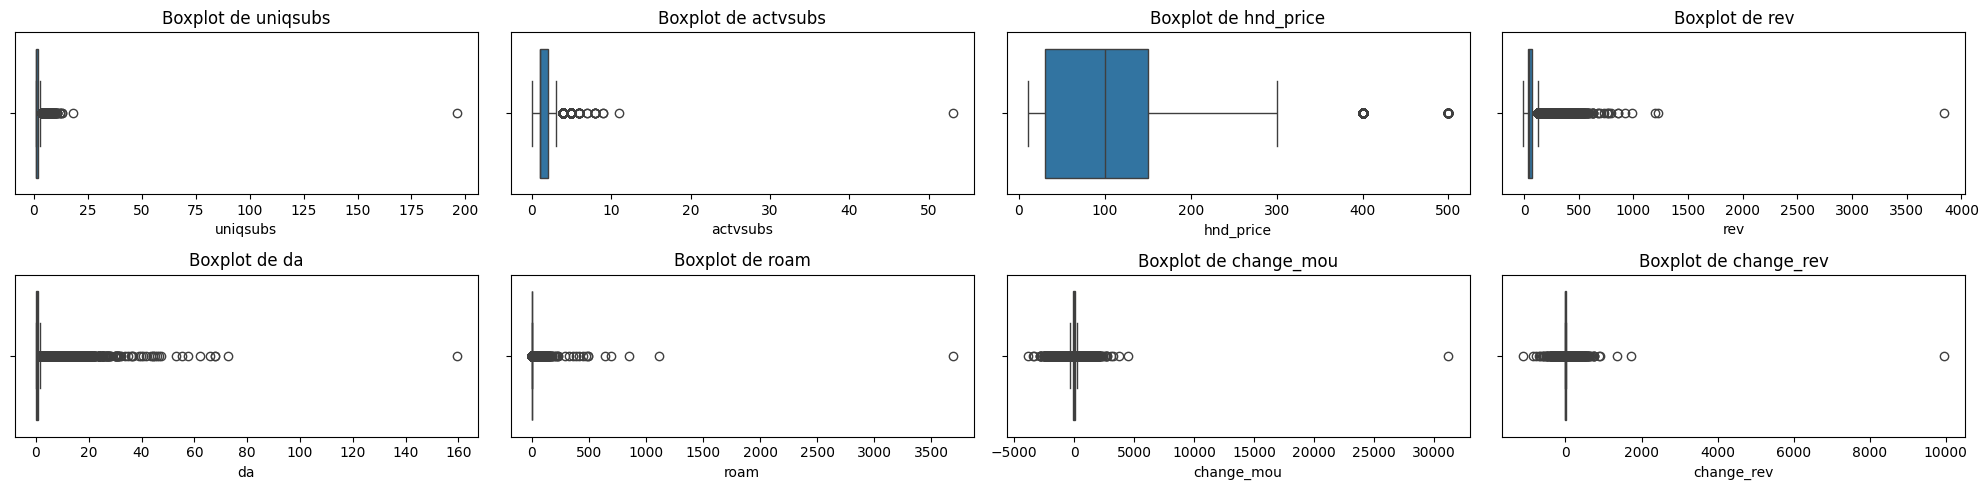

In [67]:
# Visualizamos columnas con ouliers significativos
visualizar_variables_numericas_box(df_clean, lista_outlyers, num_cols=4) # f4

Para tratar los outliers, crearemos una clase personalizada que impute la mediana y aplicaremos la misma transformación al conjunto de datos de predicción

In [69]:
# Instanciar el OutlierImputer
outlier_imputer = OutlierImputer(columns=lista_outlyers,factor=50) # c2

# Ajustar y transformar el conjunto de train_test
df_clean = outlier_imputer.fit_transform(df_clean)

# Aplicar la misma transformación al conjunto de predecir
df_clean_predecir = outlier_imputer.transform(df_clean_predecir)

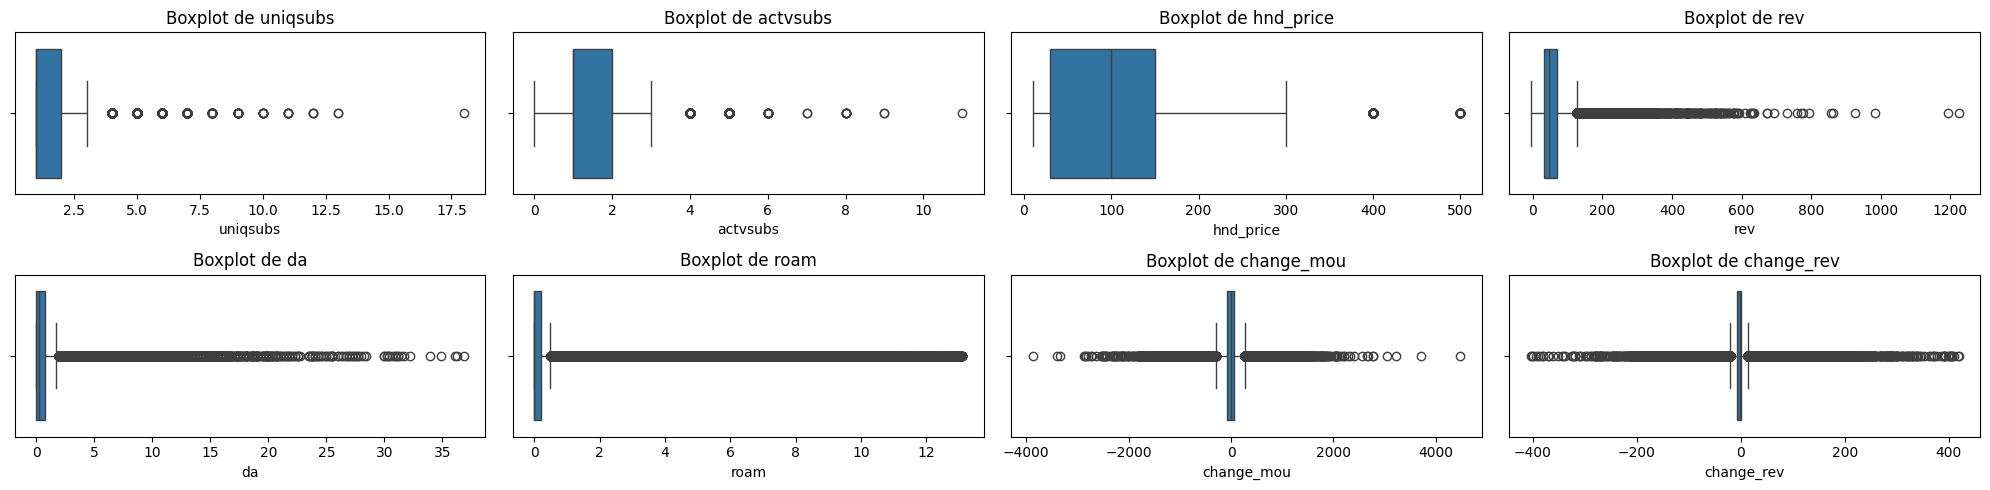

In [70]:
# Visualizamos columnas que tenía ouliers
visualizar_variables_numericas_box(df_clean, lista_outlyers, num_cols=4) # f4

# Eliminar alta correlación

* Analizar variables (X) altamente correlacionadas
* Eliminar una variable de cada pareja altamente correlacionada (>95% o >99%...) en el dataset (df)

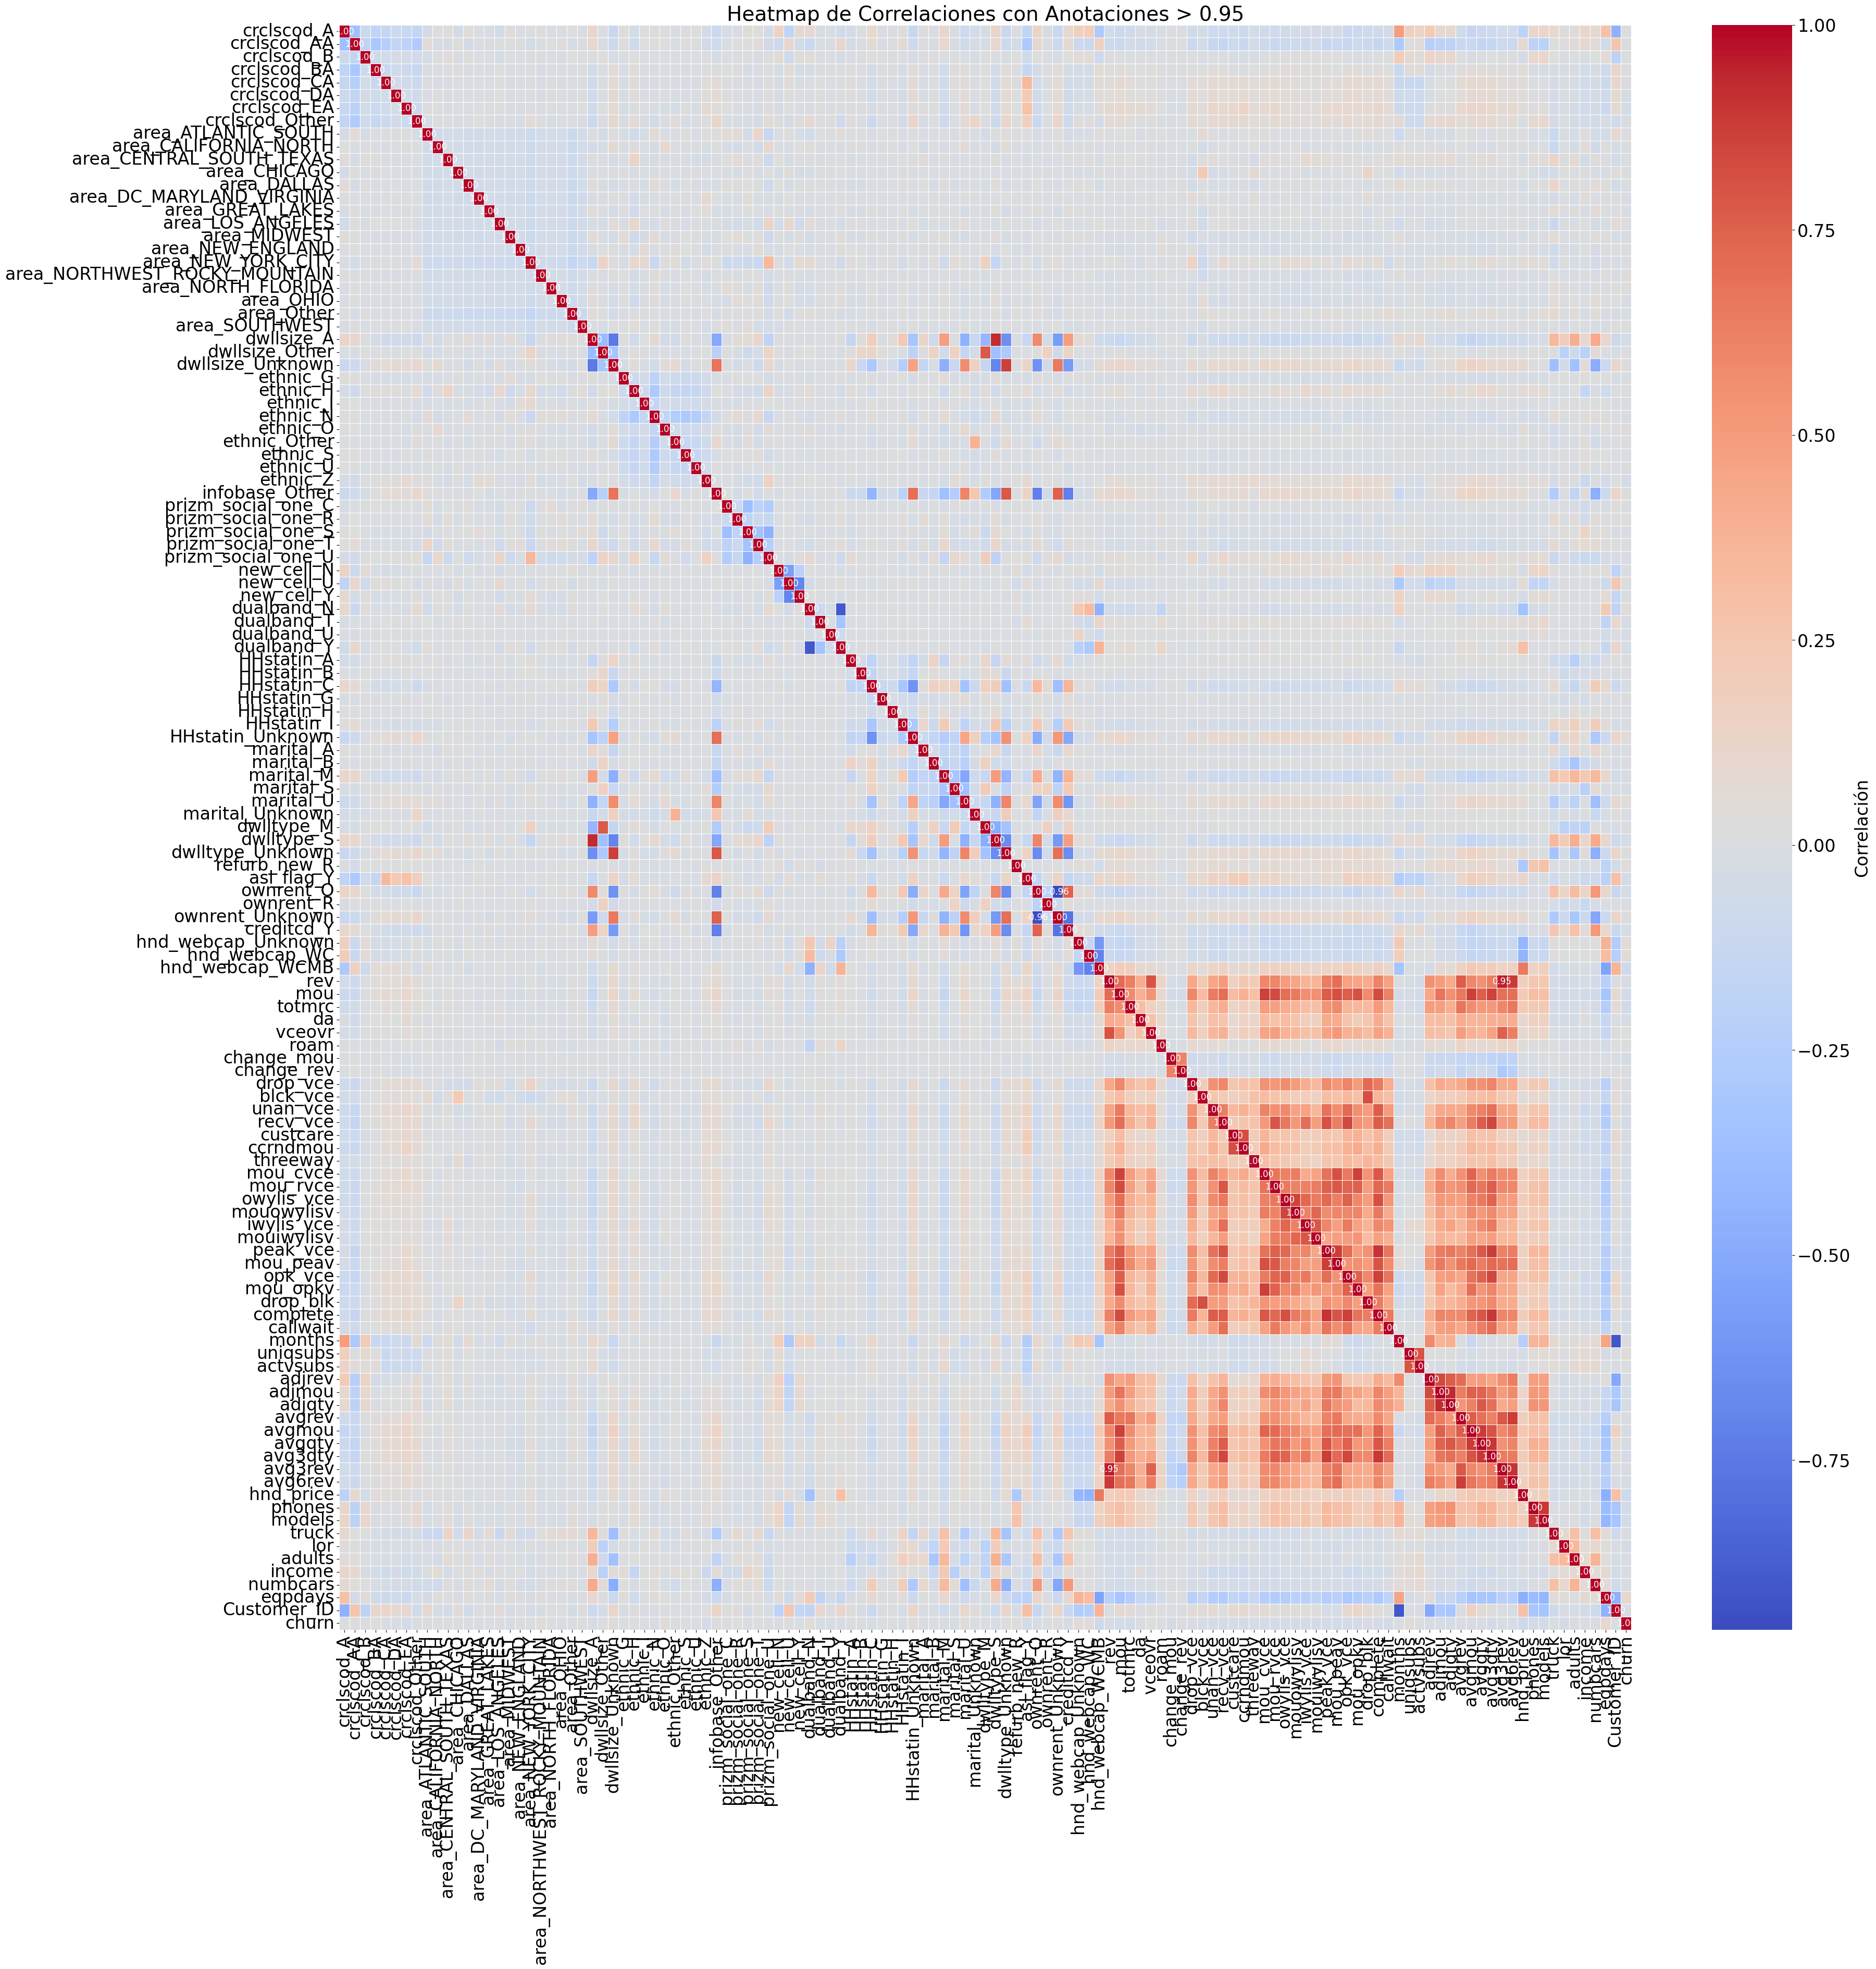

Columnas a eliminar:
 ['avg3rev', 'ownrent_Unknown']


In [71]:
# Visualizar la correlación
columns_to_drop_corr = plot_correlation_and_find_columns_to_drop(df_clean, df_clean.columns) # f5
print(f"Columnas a eliminar:\n {columns_to_drop_corr}")

In [72]:
# Eliminar columnas correlacionadas
df_clean=df_clean.drop(columns=columns_to_drop_corr)
df_clean_predecir=df_clean_predecir.drop(columns=columns_to_drop_corr)

# Eliminar baja varianza

* Eliminar variables (X) practicamente constantes con un threshold minimo (1% o menos)

In [73]:
# Revisamos la estadística de las columnas
resultado_final=obtener_estadisticas(df_clean,val_unique=5).sort_values(by="%_top", ascending=False) # f2
resultado_final

count        mean       std         min  \
dualband_U                     89897.0        0.00      0.04        0.00   
HHstatin_H                     89897.0        0.01      0.10        0.00   
marital_Unknown                89897.0        0.02      0.13        0.00   
HHstatin_G                     89897.0        0.02      0.13        0.00   
ownrent_R                      89897.0        0.02      0.14        0.00   
HHstatin_B                     89897.0        0.03      0.18        0.00   
crclscod_DA                    89897.0        0.04      0.19        0.00   
dualband_T                     89897.0        0.04      0.19        0.00   
ethnic_I                       89897.0        0.04      0.19        0.00   
crclscod_B                     89897.0        0.04      0.20        0.00   
ethnic_O                       89897.0        0.04      0.20        0.00   
area_CENTRAL_SOUTH_TEXAS       89897.0        0.04      0.21        0.00   
ethnic_Z                       89897.0        0.04      0.21        0.00   
area_NORTH_FLORIDA             89897.0        0.04      0.21        0.00   
area_NORTHWEST_ROCKY_MOUNTAIN  89897.0        0.04      0.21        0.00   
HHstatin_A                     89897.0        0.05      0.21        0.00   
area_OHIO                      89897.0        0.05      0.21        0.00   
area_GREAT_LAKES               89897.0        0.05      0.21        0.00   
prizm_social_one_R             89897.0        0.05      0.22        0.00   
area_LOS_ANGELES               89897.0        0.05      0.22        0.00   
marital_A                      89897.0        0.05      0.22        0.00   
area_CHICAGO                   89897.0        0.05      0.22        0.00   
area_SOUTHWEST                 89897.0        0.06      0.23        0.00   
area_NEW_ENGLAND               89897.0        0.06      0.23        0.00   
area_DALLAS                    89897.0        0.06      0.23        0.00   
ethnic_G                       89897.0        0.06      0.24        0.00   
area_CALIFORNIA_NORTH          89897.0        0.06      0.24        0.00   
crclscod_EA                    89897.0        0.06      0.24        0.00   
area_ATLANTIC_SOUTH            89897.0        0.06      0.24        0.00   
area_MIDWEST                   89897.0        0.07      0.25        0.00   
area_DC_MARYLAND_VIRGINIA      89897.0        0.07      0.25        0.00   
marital_B                      89897.0        0.07      0.26        0.00   
crclscod_CA                    89897.0        0.08      0.27        0.00   
crclscod_Other                 89897.0        0.10      0.30        0.00   
ethnic_Other                   89897.0        0.10      0.30        0.00   
hnd_webcap_Unknown             89897.0        0.11      0.31        0.00   
ethnic_U                       89897.0        0.11      0.31        0.00   
area_NEW_YORK_CITY             89897.0        0.11      0.32        0.00   
asl_flag_Y                     89897.0        0.12      0.32        0.00   
crclscod_BA                    89897.0        0.13      0.33        0.00   
HHstatin_I                     89897.0        0.13      0.33        0.00   
ethnic_S                       89897.0        0.13      0.34        0.00   
area_Other                     89897.0        0.13      0.34        0.00   
ethnic_H                       89897.0        0.13      0.34        0.00   
hnd_webcap_WC                  89897.0        0.14      0.35        0.00   
new_cell_N                     89897.0        0.15      0.35        0.00   
dwllsize_Other                 89897.0        0.15      0.35        0.00   
refurb_new_R                   89897.0        0.15      0.36        0.00   
prizm_social_one_T             89897.0        0.15      0.36        0.00   
prizm_social_one_C             89897.0        0.17      0.38        0.00   
crclscod_A                     89897.0        0.17      0.38        0.00   
marital_S                      89897.0        0.18      0.38        0.00   
truck

Se observa, al ordenar de manera descendente por el %_Top, que el porcentaje de la categoría mayoritaria en las columnas tiene percentiles 25-75% lleno de ceros hasta alcanzar un 76% en el %_Top. Por lo tanto, se eliminarán dichas variables.

In [74]:
# Crear lista de columnas con el 76% de ceros como valor dominante
lista_to_drop_final=resultado_final[resultado_final["%_top"]>76].index.to_list()
print(f"Eliminaremos {len(lista_to_drop_final)} columnas")

Eliminaremos 58 columnas


In [75]:
# Eliminamos columnas con dominantes valores nulos
df_clean=df_clean.drop(columns=lista_to_drop_final)
df_clean_predecir=df_clean_predecir.drop(columns=lista_to_drop_final)

# Guardar clean data

* Guardar en data path y mostrar el resultado en un head()

In [76]:
# Guardar los DataFrames en archivos pickle
df_clean.to_pickle('/content/drive/MyDrive/DSC-07-dscesp-0624-Entregable 2- Kovylina, Talón, González, Benítez y Arderiu/data/df_clean.pkl')
df_clean_predecir.to_pickle('/content/drive/MyDrive/DSC-07-dscesp-0624-Entregable 2- Kovylina, Talón, González, Benítez y Arderiu/data/df_clean_predecir.pkl')

In [77]:
# Mostrar datos de TrainTest
df_clean.head()

crclscod_AA  dwllsize_A  dwllsize_Unknown  ethnic_N  prizm_social_one_S  \
0          0.0         1.0               0.0       1.0                 1.0   
1          0.0         1.0               0.0       0.0                 0.0   
2          0.0         1.0               0.0       1.0                 1.0   
3          0.0         0.0               0.0       0.0                 0.0   
4          0.0         0.0               0.0       0.0                 0.0   

   new_cell_U  dualband_Y  HHstatin_C  HHstatin_Unknown  marital_M  marital_U  \
0         1.0         1.0         1.0               0.0        0.0        0.0   
1         0.0         0.0         1.0               0.0        0.0        0.0   
2         0.0         0.0         1.0               0.0        1.0        0.0   
3         0.0         0.0         1.0               0.0        1.0        0.0   
4         0.0         1.0         1.0               0.0        0.0        0.0   

   dwlltype_S  dwlltype_Unknown  ownrent_O  creditcd_Y  hnd_webcap_WCMB  \
0         1.0               0.0        1.0         1.0              1.0   
1         1.0               0.0        0.0         1.0              0.0   
2         1.0               0.0        1.0         1.0              0.0   
3         0.0               0.0        0.0         1.0              0.0   
4         0.0               0.0        0.0         1.0              1.0   

       rev     mou  totmrc      da  vceovr  roam  change_mou  change_rev  \
0  23.9975  219.25  22.500  0.2475     0.0   0.0     -157.25    -18.9975   
1  57.4925  482.75  37.425  0.2475     9.1   0.0      532.25     50.9875   
2  16.9900   10.25  16.990  0.0000     0.0   0.0       -4.25      0.0000   
3  38.0000    7.50  38.000  0.0000     0.0   0.0       -1.50      0.0000   
4  55.2300  570.50  71.980  0.0000     0.0   0.0       38.50      0.0000   

   drop_vce  blck_vce   unan_vce   recv_vce  custcare   ccrndmou  threeway  \
0  0.666667  0.666667   6.333333  42.333333  0.000000   0.000000  0.000000   
1  8.333333  1.000000  61.333333  69.000000  1.666667   6.333333  0.333333   
2  0.333333  0.000000   2.666667   0.333333  0.000000   0.000000  0.000000   
3  0.000000  0.000000   0.000000   1.333333  0.000000   0.000000  0.000000   
4  9.666667  0.666667  77.000000  94.666667  8.666667  15.000000  0.000000   

     mou_cvce    mou_rvce  owylis_vce  mouowylisv  iwylis_vce  mouiwylisv  \
0   90.643333   97.176667    0.000000    0.000000    0.000000    0.000000   
1  189.396667   55.280000   46.333333   24.216667    6.333333    3.696667   
2    5.426667    0.000000    0.000000    0.000000    0.000000    0.000000   
3    8.410000    0.413333    0.333333    0.256667    0.000000    0.000000   
4  285.233333  106.330000   14.666667   10.816667    0.666667    0.366667   

    peak_vce    mou_peav     opk_vce    mou_opkv   drop_blk    complete  \
0  58.000000  132.600000   24.000000   55.220000   1.333333   45.000000   
1  83.666667   75.333333  157.000000  169.343333   9.333333  193.333333   
2   5.000000    5.193333    1.000000    0.233333   0.333333    6.000000   
3   1.333333    3.380000    3.666667    5.450000   0.000000    3.666667   
4  97.333333  173.476667   90.333333  218.086667  10.333333  137.000000   

   callwait  months  uniqsubs  actvsubs   adjrev    adjmou  adjqty  avgrev  \
0  0.333333      61       2.0       1.0  1453.44   4085.00    1602   29.66   
1  5.666667      56       1.0       1.0  2833.88  26367.00   14624   51.53   
2  0.000000      58       1.0       1.0  1934.47  24303.05    7888   34.54   
3  0.000000      60       1.0       1.0  1941.81   3035.00    1479   40.45   
4  0.000000      57       1.0       1.0  2166.48  13965.00    4452   38.69   

   avgmou  avgqty  avg3qty  avg6rev  hnd_price  phones  models   lor  adults  \
0   83.37   32.69      116     38.0  149.98999     2.0     2.0  15.0     1.0   
1  479.40  265.89      158     48.0   99.98999     7.0     6.0   1.0     1.0   
2  433.98  140.86        7     17.0   29.98999 

In [78]:
# Mostrar datos de Predecir
df_clean_predecir.head()

crclscod_AA  dwllsize_A  dwllsize_Unknown  ethnic_N  prizm_social_one_S  \
0          1.0         0.0               1.0       0.0                 0.0   
1          0.0         0.0               1.0       1.0                 0.0   
2          0.0         1.0               0.0       1.0                 0.0   
3          1.0         1.0               0.0       0.0                 1.0   
4          0.0         0.0               1.0       1.0                 0.0   

   new_cell_U  dualband_Y  HHstatin_C  HHstatin_Unknown  marital_M  marital_U  \
0         1.0         1.0         1.0               0.0        1.0        0.0   
1         1.0         0.0         0.0               1.0        0.0        1.0   
2         0.0         0.0         1.0               0.0        1.0        0.0   
3         1.0         0.0         0.0               1.0        0.0        1.0   
4         1.0         1.0         1.0               0.0        0.0        0.0   

   dwlltype_S  dwlltype_Unknown  ownrent_O  creditcd_Y  hnd_webcap_WCMB  \
0         0.0               0.0        0.0         1.0              1.0   
1         0.0               1.0        0.0         0.0              1.0   
2         1.0               0.0        1.0         1.0              1.0   
3         1.0               0.0        1.0         1.0              1.0   
4         0.0               1.0        1.0         1.0              1.0   

        rev      mou    totmrc      da  vceovr    roam  change_mou  \
0   30.8350   136.75   29.9900  0.2475     0.5  0.0975       48.25   
1   35.8475   352.75   24.2700  0.4950     8.7  1.8000     -352.75   
2   30.3275   241.50   39.9900  0.0000     0.0  0.0000      -86.50   
3  154.6925  2297.00  149.9900  4.7025     0.0  0.0000      119.00   
4  156.0050   542.25   48.9475  0.7425    28.1  0.0000      195.75   

   change_rev   drop_vce   blck_vce    unan_vce    recv_vce   custcare  \
0      1.1550   2.000000  10.333333   13.333333    3.333333   1.333333   
1    -35.8475   9.000000   0.000000   10.000000   31.000000   3.666667   
2      0.8625   2.000000   4.666667   20.666667   26.666667   4.333333   
3      0.2475  20.333333   5.000000  329.333333  628.000000   0.333333   
4     40.0150   5.666667   0.666667   46.333333   11.333333  21.666667   

    ccrndmou  threeway    mou_cvce    mou_rvce  owylis_vce  mouowylisv  \
0   1.333333  0.333333   71.746667    5.406667    1.333333    0.713333   
1   9.000000  1.333333   98.543333   83.666667   15.666667   12.683333   
2   6.333333  1.666667  143.530000   27.373333    9.666667    3.760000   
3   0.666667  0.000000  769.136667  679.020000  271.000000  167.090000   
4  48.000000  0.333333  343.066667   11.243333   13.000000   14.563333   

   iwylis_vce  mouiwylisv    peak_vce    mou_peav     opk_vce    mou_opkv  \
0    0.333333    0.473333   30.000000   54.500000   13.666667   22.653333   
1    1.333333   14.286667   38.000000  106.926667   43.666667   75.283333   
2   19.666667   21.736667   48.666667   76.356667   36.000000   94.543333   
3   68.666667  150.656667  723.000000  961.736667  346.000000  486.420000   
4    1.333333    2.100000   91.000000  205.216667   31.000000  149.096667   

    drop_blk    complete  callwait  months  uniqsubs  actvsubs   adjrev  \
0  12.333333   40.666667  0.000000       7       1.0       1.0   182.94   
1   9.000000   66.333333  1.333333       7       1.0       1.0   305.59   
2   6.666667   59.333333  0.333333       9       2.0       2.0   219.45   
3  25.333333  723.000000  8.333333      11       1.0       1.0  2131.17   
4   6.666667  115.333333  0.666667       9       1.0       1.0   608.66   

    adjmou  adjqty  avgrev   avgmou  avgqty  avg3qty  avg6rev  hnd_price  \
0    958.0     393   30.49   159.67   65.50       52     31.0  149.98999   
1   3998.0    1634   50.93   666.33  272.33      181     51.0   99.98999   
2   1772.0     734   31.35   253.14  104.86      107     31.0  129.98999   
3  18478.0    9018  213.12  1847.80  901.80     1045    278.0   79.